In [14]:
# Cell 1: Imports
# Basic OS, date/time, and numerical libraries
import os
from datetime import datetime
import numpy as np

# Libraries for data handling and scientific computing
import xarray as xr
import dask.array as da # For handling large arrays that don't fit in memory

# PyTorch libraries for deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F # For functions like F.pad
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# PyTorch Lightning for streamlining training
import lightning.pytorch as pl

# Plotting library
import matplotlib.pyplot as plt

# Pandas for data manipulation (e.g., creating submission CSV)
import pandas as pd

In [15]:
# --------------------------------
# Cell 2 – Configuration (ResNet)
# --------------------------------
config = {
    "data": {
        "path": "processed_data_cse151b_v2_corrupted_ssp245/"
                "processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars":  ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp":    "ssp245",
        "test_months": 360,
        "batch_size":  64,
        "num_workers": 4,
    },

    # -------------  Model block -------------
    "model_resnet": {                 # ← change key
        "type": "resnet",             # ← will be parsed in your model-factory
        "arch": "resnet18",           # resnet18 / 34 / 50 / 101 …
        "in_channels": 5,             # len(input_vars)
        "out_channels": 2,            # len(output_vars)
        "pretrained": False,          # True if using ImageNet weights
        "replace_first_conv": True,   # set to True if in_channels ≠ 3
        "fc_hidden": 256,             # a small FC head before output layer
        "dropout": 0.1,               # dropout prob in the head
    },

    # --------  Optimizer / training ---------
    "training": {
        "optimizer": "AdamW",         # AdamW works well with ResNets
        "lr": 3e-4,                   # start a bit lower than 1e-3
        "weight_decay": 1e-4,
        "lr_scheduler": {
            "name": "CosineAnnealingLR",
            "T_max": 10,              # epochs for one cosine cycle
            "eta_min": 1e-5,          # minimum LR
        },
        "grad_clip": 1.0,             # clip to stabilise large grads
    },

    # -------------  Trainer block -----------
    "trainer": {
        "max_epochs": 20,
        "accelerator": "auto",
        "devices":     "auto",
        "precision":   16,            # try mixed precision for speed
        "deterministic": True,
        "num_sanity_val_steps": 0,
        # Example callbacks (uncomment if you have them in code):
        # "callbacks": [
        #     {"class_path": "pl.callbacks.ModelCheckpoint",
        #      "init_args": {"save_top_k": 2, "monitor": "val_loss"}},
        #     {"class_path": "pl.callbacks.EarlyStopping",
        #      "init_args": {"monitor": "val_loss", "patience": 5}}
        # ],
    },

    "seed": 42,
}

# Set seeds, torch float-32 matmul precision hint
pl.seed_everything(config["seed"], workers=True)

if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 7:
    torch.set_float32_matmul_precision("medium")
    print("Tensor Core utilisation enabled (‘medium’).")


Seed set to 42


In [16]:
# Cell 3: Latitude Weights Utility

def get_lat_weights(latitude_values):
    """
    Computes cosine-based area weights for each latitude.
    This accounts for the Earth's curvature, giving more weight to
    grid cells near the equator for global metrics.

    Args:
        latitude_values (np.array): Array of latitude values in degrees.

    Returns:
        np.array: Normalized latitude weights.
    """
    lat_rad = np.deg2rad(latitude_values) # Convert degrees to radians
    weights = np.cos(lat_rad)             # Cosine of latitude
    return weights / np.mean(weights)     # Normalize by the mean weight


In [17]:
# Cell 4: Normalizer Class

class Normalizer:
    """
    Handles Z-score normalization for input and output data.
    (data - mean) / std
    """
    def __init__(self):
        self.mean_in, self.std_in = None, None   # Statistics for input data
        self.mean_out, self.std_out = None, None # Statistics for output data

    def set_input_statistics(self, mean, std):
        """Sets the mean and standard deviation for input data."""
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        """Sets the mean and standard deviation for output data."""
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        """
        Normalizes the data using pre-computed statistics.

        Args:
            data (np.array or dask.array): Data to normalize.
            data_type (str): "input" or "output", to use appropriate statistics.

        Returns:
            Normalized data.
        
        Raises:
            ValueError: If statistics for the specified data_type are not set.
        """
        if data_type == "input":
            if self.mean_in is None or self.std_in is None:
                raise ValueError("Input statistics not set in Normalizer.")
            # Add a small epsilon to std to prevent division by zero if std is very small or zero
            return (data - self.mean_in) / (self.std_in + 1e-8) 
        elif data_type == "output":
            if self.mean_out is None or self.std_out is None:
                raise ValueError("Output statistics not set in Normalizer.")
            return (data - self.mean_out) / (self.std_out + 1e-8)
        else:
            raise ValueError(f"Invalid data_type '{data_type}'. Must be 'input' or 'output'.")

    def inverse_transform_output(self, data):
        """
        Applies inverse normalization to output data (predictions).

        Args:
            data (torch.Tensor or np.array): Normalized output data.

        Returns:
            Data in original physical units.

        Raises:
            ValueError: If output statistics are not set.
        """
        if self.mean_out is None or self.std_out is None:
            raise ValueError("Output statistics not set in Normalizer for inverse transform.")
        return data * (self.std_out + 1e-8) + self.mean_out


In [18]:
# ----- Dense-output ResNet-FCN ----------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

# ─── building blocks ─────────────────────────────────────────────────────────
class BasicBlock(nn.Module):
    expansion: int = 1
    def __init__(self, in_c: int, out_c: int, stride: int = 1,
                 downsample: nn.Module | None = None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_c)
        self.down  = downsample
        self.relu  = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x if self.down is None else self.down(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)


class Bottleneck(nn.Module):
    expansion: int = 4
    def __init__(self, in_c: int, out_c: int, stride: int = 1,
                 downsample: nn.Module | None = None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, stride, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_c)
        self.conv3 = nn.Conv2d(out_c, out_c * self.expansion, 1, bias=False)
        self.bn3   = nn.BatchNorm2d(out_c * self.expansion)
        self.down  = downsample
        self.relu  = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x if self.down is None else self.down(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        return self.relu(out + identity)

# ─── ResNet-FCN backbone ─────────────────────────────────────────────────────
class ResNet(nn.Module):
    """
    Returns dense (B, C_out, H, W) maps.
    Works for input H, W divisible by 8 (48×72, 96×144, …).
    """
    def __init__(self,
                 depth: int              = 18,
                 n_input_channels: int   = 5,
                 n_output_classes: int   = 2):
        super().__init__()

        cfg = {18:  (BasicBlock,  [2, 2, 2, 2]),
               34:  (BasicBlock,  [3, 4, 6, 3]),
               50:  (Bottleneck,  [3, 4, 6, 3]),
               101: (Bottleneck,  [3, 4, 23, 3]),
               152: (Bottleneck,  [3, 8, 36, 3])}[depth]

        block, layers = cfg
        self.in_c = 64

        # ── stem (/2) ────────────────────────────────────────────────────────
        self.stem = nn.Sequential(
            nn.Conv2d(n_input_channels, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1)   # /2
        )

        # ── residual stages ──────────────────────────────────────────────────
        self.layer1 = self._make_layer(block,  64, layers[0], stride=1)  # /2
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)  # /4
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)  # /8
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1)  # keep /8

        # ── prediction head ─────────────────────────────────────────────────
        self.head = nn.Conv2d(512 * block.expansion,
                              n_output_classes, kernel_size=1)

        # init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

    def _make_layer(self, block, out_c, blocks, stride):
        down = None
        if stride != 1 or self.in_c != out_c * block.expansion:
            down = nn.Sequential(
                nn.Conv2d(self.in_c, out_c * block.expansion,
                          1, stride, bias=False),
                nn.BatchNorm2d(out_c * block.expansion)
            )
        layers = [block(self.in_c, out_c, stride, down)]
        self.in_c = out_c * block.expansion
        layers += [block(self.in_c, out_c) for _ in range(1, blocks)]
        return nn.Sequential(*layers)

    # ── forward ─────────────────────────────────────────────────────────────
    def forward(self, x):
        H, W = x.shape[-2:]
        x = self.stem(x)
        x = self.layer1(x); x = self.layer2(x)
        x = self.layer3(x); x = self.layer4(x)
        x = self.head(x)                       # (B, C_out, H/8, W/8)
        return F.interpolate(x, (H, W),
                             mode='bilinear',
                             align_corners=False)


In [19]:
# Cell 6: ClimateDataset and ClimateDataModule

class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        """
        PyTorch Dataset for climate data.

        Args:
            inputs_dask (dask.array): Dask array of input features.
            outputs_dask (dask.array): Dask array of output targets.
            output_is_normalized (bool): Flag indicating if outputs_dask is already normalized.
                                         Used for the test set where targets are not pre-normalized.
        """
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any():
            raise ValueError("NaNs found in input dataset after converting to tensor.")
        if torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in output dataset after converting to tensor.")
        
        print(f"Dataset created. Input shape: {self.inputs.shape}, Output shape: {self.outputs.shape}")


    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        test_months=120,
        batch_size=32,
        num_workers=0,
        seed=42, 
    ):
        super().__init__()
        self.save_hyperparameters() 
        self.normalizer = Normalizer()

    def prepare_data(self):
        if not os.path.exists(self.hparams.path):
            raise FileNotFoundError(f"Data path not found: {self.hparams.path}. Please check config['data']['path'].")

    def setup(self, stage=None):
        ds = xr.open_zarr(self.hparams.path, consolidated=False, chunks={"time": 24})
        
        # --- FIX for spatial_template ---
        # The 'rsdt' variable might not have 'member_id'. Handle this conditionally.
        rsdt_var_for_template = ds["rsdt"]
        if "member_id" in rsdt_var_for_template.dims:
            spatial_template = rsdt_var_for_template.isel(time=0, ssp=0, member_id=0, drop=True)
        else:
            # If 'member_id' is not present, select without it.
            # This assumes 'rsdt' is consistent across members or doesn't have that dimension.
            spatial_template = rsdt_var_for_template.isel(time=0, ssp=0, drop=True)
        # --- END FIX ---

        def load_ssp(ssp_name):
            input_dask_list, output_dask_list = [], []
            
            for var_name in self.hparams.input_vars:
                da_var = ds[var_name].sel(ssp=ssp_name)
                if "latitude" in da_var.dims: 
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                # For input variables, if member_id exists, select the target_member_id.
                # If it doesn't exist (e.g. for some forcing data), this sel will be a no-op if strict=False,
                # or we can check existence. Xarray's sel is usually robust if the dim doesn't exist.
                # However, to be safe, let's check.
                if "member_id" in da_var.dims:
                    da_var = da_var.sel(member_id=self.hparams.target_member_id)
                
                if set(da_var.dims) == {"time"}: 
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask_list.append(da_var.data)
            
            for var_name in self.hparams.output_vars:
                # Output variables are always selected by target_member_id
                da_out = ds[var_name].sel(ssp=ssp_name, member_id=self.hparams.target_member_id)
                if "latitude" in da_out.dims: 
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask_list.append(da_out.data)

            return da.stack(input_dask_list, axis=1), da.stack(output_dask_list, axis=1)

        train_input_list, train_output_list = [], []
        val_input_ssp370, val_output_ssp370 = None, None

        for ssp in self.hparams.train_ssps:
            x_ssp, y_ssp = load_ssp(ssp)
            if ssp == "ssp370": 
                val_input_ssp370 = x_ssp[-self.hparams.test_months:]
                val_output_ssp370 = y_ssp[-self.hparams.test_months:]
                train_input_list.append(x_ssp[:-self.hparams.test_months])
                train_output_list.append(y_ssp[:-self.hparams.test_months])
            else:
                train_input_list.append(x_ssp)
                train_output_list.append(y_ssp)
        
        train_input_all_ssp = da.concatenate(train_input_list, axis=0)
        train_output_all_ssp = da.concatenate(train_output_list, axis=0)

        input_mean = da.nanmean(train_input_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        input_std = da.nanstd(train_input_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        self.normalizer.set_input_statistics(mean=input_mean, std=input_std)

        output_mean = da.nanmean(train_output_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        output_std = da.nanstd(train_output_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        self.normalizer.set_output_statistics(mean=output_mean, std=output_std)

        train_input_norm = self.normalizer.normalize(train_input_all_ssp, "input")
        train_output_norm = self.normalizer.normalize(train_output_all_ssp, "output")
        
        val_input_norm = self.normalizer.normalize(val_input_ssp370, "input")
        val_output_norm = self.normalizer.normalize(val_output_ssp370, "output")

        test_input_ssp, test_output_ssp = load_ssp(self.hparams.test_ssp)
        test_input_ssp = test_input_ssp[-self.hparams.test_months:] 
        test_output_ssp = test_output_ssp[-self.hparams.test_months:]
        test_input_norm = self.normalizer.normalize(test_input_ssp, "input")

        if stage == "fit" or stage is None:
            self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
            self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)
        if stage == "test" or stage is None:
            self.test_dataset = ClimateDataset(test_input_norm, test_output_ssp, output_is_normalized=False)
        
        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

        ds.close()

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.hparams.batch_size, shuffle=True,
                          num_workers=self.hparams.num_workers, pin_memory=torch.cuda.is_available(), persistent_workers=self.hparams.num_workers > 0)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.hparams.batch_size, shuffle=False,
                          num_workers=self.hparams.num_workers, pin_memory=torch.cuda.is_available(), persistent_workers=self.hparams.num_workers > 0)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.hparams.batch_size, shuffle=False,
                          num_workers=self.hparams.num_workers, pin_memory=torch.cuda.is_available(), persistent_workers=self.hparams.num_workers > 0)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon


In [20]:
# Cell 7: ClimateEmulationModule (PyTorch Lightning)

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model 
        self.save_hyperparameters(ignore=['model']) 
        
        self.criterion = nn.MSELoss() 
        self.normalizer = None 
        
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []

    def forward(self, x):
        return self.model(x)

    def _get_normalizer_from_datamodule(self):
        """Helper to safely get normalizer from datamodule."""
        if hasattr(self.trainer, 'datamodule') and self.trainer.datamodule is not None and hasattr(self.trainer.datamodule, 'normalizer'):
            return self.trainer.datamodule.normalizer
        else:
            # Fallback if trainer.datamodule is not set up (e.g. direct call to test without fit)
            # This requires 'config' to be globally accessible or passed differently.
            print("Warning: Normalizer not found via self.trainer.datamodule. Attempting fallback initialization.")
            temp_dm = ClimateDataModule(**config["data"]) 
            temp_dm.prepare_data()
            temp_dm.setup(stage="test") # Or appropriate stage to ensure normalizer stats are computed
            return temp_dm.normalizer


    def on_fit_start(self):
        """Called at the beginning of training."""
        self.normalizer = self._get_normalizer_from_datamodule()

    def on_test_start(self):
        """Called at the beginning of testing."""
        if self.normalizer is None: # Ensure normalizer is available
            self.normalizer = self._get_normalizer_from_datamodule()


    def training_step(self, batch, batch_idx):
        x, y_norm = batch 
        y_hat_norm = self(x)   
        loss = self.criterion(y_hat_norm, y_norm)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y_norm = batch
        y_hat_norm = self(x)
        loss = self.criterion(y_hat_norm, y_norm)
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()

        y_hat_denorm = self.normalizer.inverse_transform_output(y_hat_norm.detach().cpu().numpy())
        y_denorm = self.normalizer.inverse_transform_output(y_norm.detach().cpu().numpy())
        
        self.val_preds.append(y_hat_denorm)
        self.val_targets.append(y_denorm)
        return loss 

    def on_validation_epoch_end(self):
        if not self.trainer.sanity_checking: # Skip during sanity check
            if not self.val_preds or not self.val_targets: 
                return

            preds_epoch = np.concatenate(self.val_preds, axis=0)
            trues_epoch = np.concatenate(self.val_targets, axis=0)
            
            if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()
            
            self._evaluate(preds_epoch, trues_epoch, phase="val")
            
            np.save("val_preds.npy", preds_epoch)
            np.save("val_trues.npy", trues_epoch)
            
            self.val_preds.clear() 
            self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y_true_denorm = batch 
        y_hat_norm = self(x)    

        if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()
        
        y_hat_denorm = self.normalizer.inverse_transform_output(y_hat_norm.detach().cpu().numpy())
        
        self.test_preds.append(y_hat_denorm)
        self.test_targets.append(y_true_denorm.detach().cpu().numpy()) 

    def on_test_epoch_end(self):
        if not self.test_preds or not self.test_targets: 
            return

        preds_epoch = np.concatenate(self.test_preds, axis=0)
        trues_epoch = np.concatenate(self.test_targets, axis=0)

        if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()

        self._evaluate(preds_epoch, trues_epoch, phase="test")
        self._save_submission(preds_epoch) 
        
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

    def _evaluate(self, preds_np, trues_np, phase="val"):
        """Calculates and logs evaluation metrics."""
        # This check is important for when _evaluate might be called outside trainer.fit/test context
        # or if datamodule is not correctly propagated.
        if self.trainer.datamodule is None or not hasattr(self.trainer.datamodule, 'get_lat_weights'):
            print("Warning: self.trainer.datamodule not fully available in _evaluate. Using fallback for coords/weights.")
            dm_eval = ClimateDataModule(**config["data"]) # Re-init for coords, assumes global config
            dm_eval.prepare_data()
            dm_eval.setup(stage=phase) # Setup for the correct stage
            area_weights = dm_eval.get_lat_weights()
            lat, lon = dm_eval.get_coords()
            output_vars = dm_eval.hparams.output_vars
        else:
            area_weights = self.trainer.datamodule.get_lat_weights()
            lat, lon = self.trainer.datamodule.get_coords()
            output_vars = self.trainer.datamodule.hparams.output_vars


        time_coords = np.arange(preds_np.shape[0])
        metrics_summary = {}

        for i, var_name in enumerate(output_vars):
            p_var = preds_np[:, i] 
            t_var = trues_np[:, i] 
            
            p_xr = xr.DataArray(p_var, dims=["time", "y", "x"], coords={"time": time_coords, "y": lat, "x": lon})
            t_xr = xr.DataArray(t_var, dims=["time", "y", "x"], coords={"time": time_coords, "y": lat, "x": lon})

            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean()).item()
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean()).item()
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean().item()

            print(f"[{phase.upper()}] {var_name}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            
            metrics_summary[f"{phase}/{var_name}/rmse"] = rmse
            metrics_summary[f"{phase}/{var_name}/time_mean_rmse"] = mean_rmse
            metrics_summary[f"{phase}/{var_name}/time_std_mae"] = std_mae
        
        self.log_dict(metrics_summary, logger=True)

    def _save_submission(self, predictions_np):
        """Saves model predictions to a CSV file in Kaggle submission format."""
        if self.trainer.datamodule is None or not hasattr(self.trainer.datamodule, 'get_coords'):
            print("Warning: self.trainer.datamodule not fully available in _save_submission. Using fallback.")
            dm_submission = ClimateDataModule(**config["data"])
            dm_submission.prepare_data()
            dm_submission.setup(stage="test") # Ensure coords are loaded
            lat, lon = dm_submission.get_coords()
            output_vars = dm_submission.hparams.output_vars
        else:
            lat, lon = self.trainer.datamodule.get_coords()
            output_vars = self.trainer.datamodule.hparams.output_vars
            
        time_coords_submission = np.arange(predictions_np.shape[0])

        rows = []
        for t_idx, t_val in enumerate(time_coords_submission):
            for var_idx, var_name in enumerate(output_vars):
                for y_idx, y_val in enumerate(lat):
                    for x_idx, x_val in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var_name}_{y_val:.2f}_{x_val:.2f}"
                        pred_value = predictions_np[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred_value})

        submission_df = pd.DataFrame(rows)
        submission_dir = "submissions"
        os.makedirs(submission_dir, exist_ok=True)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filepath = os.path.join(submission_dir, f"kaggle_submission_unet_{timestamp}.csv")
        submission_df.to_csv(filepath, index=False)
        print(f"Submission saved to: {filepath}")


In [22]:
# import os
# import itertools
# import types
# import torch.optim as optim
# import lightning.pytorch as pl
# from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar

# print("\n--- Starting ResNet Grid Search ---")

# MAX_EPOCHS = 20
# # 1. Define hyperparameter combinations
# hyperparameter_sets = [
#     # your original four
#     {"depth": 18, "lr": 1e-3, "optimizer_type": "AdamW", "weight_decay": 0.0,  "scheduler_type": "CosineAnnealingLR", "batch_size": 32},
#     {"depth": 18, "lr": 5e-4, "optimizer_type": "Adam",  "weight_decay": 1e-2, "scheduler_type": None,                 "batch_size": 32},
#     {"depth": 34, "lr": 1e-3, "optimizer_type": "AdamW", "weight_decay": 0.0,  "scheduler_type": "CosineAnnealingLR", "batch_size": 16},
#     {"depth": 34, "lr": 5e-4, "optimizer_type": "Adam",  "weight_decay": 1e-2, "scheduler_type": None,                 "batch_size": 16},

#     # six additional combos
#     {"depth": 18, "lr": 1e-4, "optimizer_type": "AdamW", "weight_decay": 1e-2, "scheduler_type": "CosineAnnealingLR", "batch_size": 64},
#     {"depth": 18, "lr": 5e-4, "optimizer_type": "AdamW", "weight_decay": 0.0,  "scheduler_type": None,                  "batch_size": 64},
#     {"depth": 34, "lr": 1e-4, "optimizer_type": "Adam",  "weight_decay": 1e-2, "scheduler_type": "CosineAnnealingLR", "batch_size": 64},
#     {"depth": 34, "lr": 5e-4, "optimizer_type": "AdamW", "weight_decay": 1e-2, "scheduler_type": None,                  "batch_size": 32},
#     {"depth": 50, "lr": 5e-4, "optimizer_type": "AdamW", "weight_decay": 1e-2, "scheduler_type": "CosineAnnealingLR", "batch_size": 32},
#     {"depth": 50, "lr": 1e-3, "optimizer_type": "Adam",  "weight_decay": 0.0,  "scheduler_type": None,                  "batch_size": 16},
# ]


# results = []
# base_trainer_cfg = {
#     k: v for k, v in config["trainer"].items()
#     if k not in ["callbacks", "default_root_dir"]
# }

# for i, params in enumerate(hyperparameter_sets, 1):
#     print(f"\n--- Run {i}/{len(hyperparameter_sets)} — {params} ---")

#     # A) Update data batch_size
#     cfg = deepcopy(config)
#     cfg["data"]["batch_size"] = params["batch_size"]
#     datamodule_gs = ClimateDataModule(**cfg["data"])

#     # B) Instantiate ResNet backbone
#     n_in  = len(cfg["data"]["input_vars"])
#     n_out = len(cfg["data"]["output_vars"])
#     backbone = ResNet(
#         depth=params["depth"],
#         n_input_channels=n_in,
#         n_output_classes=n_out
#     )

#     # C) Wrap in LightningModule
#     lm = ClimateEmulationModule(backbone, learning_rate=params["lr"])

#     # D) Monkey-patch optimizers
#     def custom_opt(self):
#         if params["optimizer_type"] == "AdamW":
#             opt = optim.AdamW(self.parameters(),
#                               lr=self.hparams.learning_rate,
#                               weight_decay=params["weight_decay"])
#         else:
#             opt = optim.Adam(self.parameters(),
#                              lr=self.hparams.learning_rate,
#                              weight_decay=params["weight_decay"])

#         if params["scheduler_type"] == "CosineAnnealingLR":
#             sched = optim.lr_scheduler.CosineAnnealingLR(
#                 opt, eta_min=1e-6
#             )
#             return {"optimizer": opt,
#                     "lr_scheduler": {"scheduler": sched, "interval": "epoch"}}
#         return opt

#     lm.configure_optimizers = types.MethodType(custom_opt, lm)

#     # E) Prepare callbacks & Trainer
#     run_dir = f"gs_resnet_run_{i}"
#     ckpt_cb = ModelCheckpoint(
#         monitor="val/loss",
#         mode="min",
#         dirpath=os.path.join("lightning_logs", run_dir, "checkpoints"),
#         filename=f"resnet-d{params['depth']}-{{epoch:02d}}-{{val/loss:.2f}}",
#         save_top_k=1
#     )
#     es_cb  = EarlyStopping(monitor="val/loss", patience=3, mode="min")
#     pb_cb  = TQDMProgressBar(refresh_rate=10)

#     trainer = pl.Trainer(
#         default_root_dir=os.path.join("lightning_logs", run_dir),
#         callbacks=[ckpt_cb, es_cb, pb_cb],
#         **base_trainer_cfg
#     )

#     # F) Fit and validate
#     trainer.fit(lm, datamodule=datamodule_gs)
#     val_metrics = trainer.validate(lm, datamodule=datamodule_gs, ckpt_path="best")[0]
#     val_loss = val_metrics.get("val/loss", float("inf"))
#     print(f"→ Run {i} val/loss = {val_loss:.4f}")

#     results.append({
#         "params": params,
#         "val_loss": val_loss,
#         "metrics": val_metrics
#     })

# # 2) Summarize grid search
# best = min(results, key=lambda x: x["val_loss"])
# print("\n--- GRID SEARCH COMPLETE ---")
# print("Best hyperparameters:")
# for k, v in best["params"].items():
#     print(f" • {k}: {v}")
# print(f"Final validation loss: {best['val_loss']:.4f}")
# print("Full metrics:", best["metrics"])



--- Starting ResNet Grid Search ---

--- Run 1/10 — {'depth': 18, 'lr': 0.001, 'optimizer_type': 'AdamW', 'weight_decay': 0.0, 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32} ---


/home/ruz039/.local/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Dataset created. Input shape: torch.Size([2703, 5, 48, 72]), Output shape: torch.Size([2703, 2, 48, 72])
Creating dataset with 360 samples...


/home/ruz039/.local/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_1/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | ResNet  | 11.2 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.684    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([360, 5, 48, 72]), Output shape: torch.Size([360, 2, 48, 72])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.4281, Time-Mean RMSE=4.4666, Time-Stddev MAE=2.1137
[VAL] pr: RMSE=3.2713, Time-Mean RMSE=1.7908, Time-Stddev MAE=1.7496


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.6157, Time-Mean RMSE=3.6525, Time-Stddev MAE=1.8489
[VAL] pr: RMSE=3.2169, Time-Mean RMSE=1.7308, Time-Stddev MAE=1.6755


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.5285, Time-Mean RMSE=3.8057, Time-Stddev MAE=1.5387
[VAL] pr: RMSE=3.1805, Time-Mean RMSE=1.6953, Time-Stddev MAE=1.6620


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.1202, Time-Mean RMSE=3.6187, Time-Stddev MAE=1.3845
[VAL] pr: RMSE=3.1520, Time-Mean RMSE=1.6696, Time-Stddev MAE=1.6091


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.5580, Time-Mean RMSE=4.2483, Time-Stddev MAE=1.4016
[VAL] pr: RMSE=3.1578, Time-Mean RMSE=1.6686, Time-Stddev MAE=1.5354


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.9977, Time-Mean RMSE=3.6249, Time-Stddev MAE=1.2644
[VAL] pr: RMSE=3.1064, Time-Mean RMSE=1.6346, Time-Stddev MAE=1.5613


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.8922, Time-Mean RMSE=3.5374, Time-Stddev MAE=1.2678
[VAL] pr: RMSE=3.0833, Time-Mean RMSE=1.6444, Time-Stddev MAE=1.4902


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.8831, Time-Mean RMSE=3.6226, Time-Stddev MAE=1.2178
[VAL] pr: RMSE=3.0806, Time-Mean RMSE=1.6417, Time-Stddev MAE=1.4579


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.7925, Time-Mean RMSE=3.5917, Time-Stddev MAE=1.2283
[VAL] pr: RMSE=3.0551, Time-Mean RMSE=1.6305, Time-Stddev MAE=1.4288


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.7244, Time-Mean RMSE=3.5698, Time-Stddev MAE=1.2135
[VAL] pr: RMSE=3.0496, Time-Mean RMSE=1.6370, Time-Stddev MAE=1.4416


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.9380, Time-Mean RMSE=3.7470, Time-Stddev MAE=1.1675
[VAL] pr: RMSE=3.0606, Time-Mean RMSE=1.6283, Time-Stddev MAE=1.4404


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.8471, Time-Mean RMSE=3.7792, Time-Stddev MAE=1.1825
[VAL] pr: RMSE=3.0393, Time-Mean RMSE=1.6358, Time-Stddev MAE=1.4207


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.6941, Time-Mean RMSE=3.5546, Time-Stddev MAE=1.2157
[VAL] pr: RMSE=3.0427, Time-Mean RMSE=1.6451, Time-Stddev MAE=1.3968


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.7063, Time-Mean RMSE=3.5815, Time-Stddev MAE=1.2190
[VAL] pr: RMSE=3.0358, Time-Mean RMSE=1.6287, Time-Stddev MAE=1.4163


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.6672, Time-Mean RMSE=3.5840, Time-Stddev MAE=1.1834
[VAL] pr: RMSE=3.0321, Time-Mean RMSE=1.6408, Time-Stddev MAE=1.3909


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5629, Time-Mean RMSE=3.5505, Time-Stddev MAE=1.1368
[VAL] pr: RMSE=3.0131, Time-Mean RMSE=1.6277, Time-Stddev MAE=1.3871


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5002, Time-Mean RMSE=3.4818, Time-Stddev MAE=1.1123
[VAL] pr: RMSE=3.0190, Time-Mean RMSE=1.6265, Time-Stddev MAE=1.4039


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5293, Time-Mean RMSE=3.5169, Time-Stddev MAE=1.1325
[VAL] pr: RMSE=3.0155, Time-Mean RMSE=1.6270, Time-Stddev MAE=1.3881


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5240, Time-Mean RMSE=3.5094, Time-Stddev MAE=1.1423
[VAL] pr: RMSE=3.0140, Time-Mean RMSE=1.6305, Time-Stddev MAE=1.3901


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5235, Time-Mean RMSE=3.5118, Time-Stddev MAE=1.1337
[VAL] pr: RMSE=3.0136, Time-Mean RMSE=1.6276, Time-Stddev MAE=1.3922


`Trainer.fit` stopped: `max_epochs=20` reached.
Restoring states from the checkpoint path at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_1/checkpoints/resnet-d18-epoch=19-val/loss=0.39.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_1/checkpoints/resnet-d18-epoch=19-val/loss=0.39.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5235, Time-Mean RMSE=3.5118, Time-Stddev MAE=1.1337
[VAL] pr: RMSE=3.0136, Time-Mean RMSE=1.6276, Time-Stddev MAE=1.3922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val/loss            0.3949071764945984
       val/pr/rmse           3.013636589050293
  val/pr/time_mean_rmse     1.6276456117630005
   val/pr/time_std_mae      1.3921518325805664
      val/tas/rmse           4.523533821105957
 val/tas/time_mean_rmse     3.5118136405944824
  val/tas/time_std_mae      1.1336572170257568
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
→ Run 1 val/loss = 0.3949

--- Run 2/10 — {'depth': 18, 'lr': 0.0005, 'optimizer_type': 'Adam', 'weight_decay': 0.01, 'schedu

/home/ruz039/.local/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Dataset created. Input shape: torch.Size([2703, 5, 48, 72]), Output shape: torch.Size([2703, 2, 48, 72])
Creating dataset with 360 samples...


/home/ruz039/.local/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_2/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | ResNet  | 11.2 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.684    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([360, 5, 48, 72]), Output shape: torch.Size([360, 2, 48, 72])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=8.3770, Time-Mean RMSE=5.8191, Time-Stddev MAE=2.9053
[VAL] pr: RMSE=3.2706, Time-Mean RMSE=1.7528, Time-Stddev MAE=1.5072


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.4388, Time-Mean RMSE=5.4634, Time-Stddev MAE=2.1358
[VAL] pr: RMSE=3.2118, Time-Mean RMSE=1.7416, Time-Stddev MAE=1.6124


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=9.8006, Time-Mean RMSE=8.4202, Time-Stddev MAE=2.1693
[VAL] pr: RMSE=3.3318, Time-Mean RMSE=1.9153, Time-Stddev MAE=1.5265


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=8.4111, Time-Mean RMSE=6.7572, Time-Stddev MAE=2.4745
[VAL] pr: RMSE=3.2139, Time-Mean RMSE=1.7600, Time-Stddev MAE=1.5394


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.4224, Time-Mean RMSE=5.1337, Time-Stddev MAE=1.5138
[VAL] pr: RMSE=3.1904, Time-Mean RMSE=1.7597, Time-Stddev MAE=1.5459


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.4029, Time-Mean RMSE=5.1160, Time-Stddev MAE=1.7558
[VAL] pr: RMSE=3.1475, Time-Mean RMSE=1.6986, Time-Stddev MAE=1.6671


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.9937, Time-Mean RMSE=3.8159, Time-Stddev MAE=1.1937
[VAL] pr: RMSE=3.0929, Time-Mean RMSE=1.6750, Time-Stddev MAE=1.5620


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.1683, Time-Mean RMSE=4.1420, Time-Stddev MAE=1.3900
[VAL] pr: RMSE=3.0655, Time-Mean RMSE=1.6697, Time-Stddev MAE=1.5189


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.7495, Time-Mean RMSE=3.6940, Time-Stddev MAE=1.2227
[VAL] pr: RMSE=3.0471, Time-Mean RMSE=1.6560, Time-Stddev MAE=1.4338


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.6625, Time-Mean RMSE=3.6994, Time-Stddev MAE=1.2020
[VAL] pr: RMSE=3.0277, Time-Mean RMSE=1.6415, Time-Stddev MAE=1.4648


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.6061, Time-Mean RMSE=3.6248, Time-Stddev MAE=1.1233
[VAL] pr: RMSE=3.0525, Time-Mean RMSE=1.6502, Time-Stddev MAE=1.5004


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.6633, Time-Mean RMSE=3.7283, Time-Stddev MAE=1.2007
[VAL] pr: RMSE=3.0326, Time-Mean RMSE=1.6351, Time-Stddev MAE=1.4740


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.3393, Time-Mean RMSE=3.5998, Time-Stddev MAE=1.0184
[VAL] pr: RMSE=2.9862, Time-Mean RMSE=1.6370, Time-Stddev MAE=1.3906


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5563, Time-Mean RMSE=3.7104, Time-Stddev MAE=1.1139
[VAL] pr: RMSE=3.0220, Time-Mean RMSE=1.6473, Time-Stddev MAE=1.4430


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.3152, Time-Mean RMSE=3.4795, Time-Stddev MAE=1.0376
[VAL] pr: RMSE=3.0066, Time-Mean RMSE=1.6246, Time-Stddev MAE=1.4207


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.3652, Time-Mean RMSE=3.5437, Time-Stddev MAE=1.5311
[VAL] pr: RMSE=3.1277, Time-Mean RMSE=1.6341, Time-Stddev MAE=1.5032


Restoring states from the checkpoint path at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_2/checkpoints/resnet-d18-epoch=12-val/loss=0.39.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_2/checkpoints/resnet-d18-epoch=12-val/loss=0.39.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.3393, Time-Mean RMSE=3.5998, Time-Stddev MAE=1.0184
[VAL] pr: RMSE=2.9862, Time-Mean RMSE=1.6370, Time-Stddev MAE=1.3906
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val/loss            0.3874010741710663
       val/pr/rmse          2.9861667156219482
  val/pr/time_mean_rmse     1.6370073556900024
   val/pr/time_std_mae      1.3906482458114624
      val/tas/rmse           4.339258670806885
 val/tas/time_mean_rmse     3.5997612476348877
  val/tas/time_std_mae       1.018449068069458
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
→ Run 2 val/loss = 0.3874

--- Run 3/10 — {'depth': 34, 'lr': 0.001, 'optimizer_type': 'AdamW', 'weight_decay': 0.0, 'schedul

/home/ruz039/.local/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Dataset created. Input shape: torch.Size([2703, 5, 48, 72]), Output shape: torch.Size([2703, 2, 48, 72])
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | ResNet  | 21.3 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.117    Total estimated model params size (MB)
117       Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([360, 5, 48, 72]), Output shape: torch.Size([360, 2, 48, 72])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.9564, Time-Mean RMSE=4.9805, Time-Stddev MAE=1.9065
[VAL] pr: RMSE=3.2468, Time-Mean RMSE=1.7197, Time-Stddev MAE=1.6102


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.0096, Time-Mean RMSE=4.1516, Time-Stddev MAE=1.4162
[VAL] pr: RMSE=3.1968, Time-Mean RMSE=1.6675, Time-Stddev MAE=1.6225


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.2892, Time-Mean RMSE=3.9171, Time-Stddev MAE=1.2781
[VAL] pr: RMSE=3.1388, Time-Mean RMSE=1.6612, Time-Stddev MAE=1.6129


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.9754, Time-Mean RMSE=3.4416, Time-Stddev MAE=1.2416
[VAL] pr: RMSE=3.0914, Time-Mean RMSE=1.6254, Time-Stddev MAE=1.4861


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.7456, Time-Mean RMSE=3.6445, Time-Stddev MAE=1.0497
[VAL] pr: RMSE=3.0633, Time-Mean RMSE=1.6395, Time-Stddev MAE=1.4304


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5861, Time-Mean RMSE=3.3058, Time-Stddev MAE=1.0310
[VAL] pr: RMSE=3.0503, Time-Mean RMSE=1.6270, Time-Stddev MAE=1.3737


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.4591, Time-Mean RMSE=3.4099, Time-Stddev MAE=1.0692
[VAL] pr: RMSE=3.0257, Time-Mean RMSE=1.6217, Time-Stddev MAE=1.3799


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.2778, Time-Mean RMSE=3.4507, Time-Stddev MAE=1.0052
[VAL] pr: RMSE=2.9812, Time-Mean RMSE=1.6200, Time-Stddev MAE=1.3466


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.1503, Time-Mean RMSE=3.3891, Time-Stddev MAE=0.9848
[VAL] pr: RMSE=2.9736, Time-Mean RMSE=1.6210, Time-Stddev MAE=1.3237


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.4090, Time-Mean RMSE=3.5111, Time-Stddev MAE=1.0091
[VAL] pr: RMSE=3.0073, Time-Mean RMSE=1.6378, Time-Stddev MAE=1.3343


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.1347, Time-Mean RMSE=3.4289, Time-Stddev MAE=0.9548
[VAL] pr: RMSE=2.9648, Time-Mean RMSE=1.6228, Time-Stddev MAE=1.3007


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.0595, Time-Mean RMSE=3.3632, Time-Stddev MAE=0.9655
[VAL] pr: RMSE=2.9572, Time-Mean RMSE=1.6224, Time-Stddev MAE=1.2985


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.0096, Time-Mean RMSE=3.3470, Time-Stddev MAE=0.9722
[VAL] pr: RMSE=2.9536, Time-Mean RMSE=1.6253, Time-Stddev MAE=1.2756


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.0543, Time-Mean RMSE=3.3966, Time-Stddev MAE=0.9752
[VAL] pr: RMSE=2.9532, Time-Mean RMSE=1.6222, Time-Stddev MAE=1.2829


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.1523, Time-Mean RMSE=3.4316, Time-Stddev MAE=0.9793
[VAL] pr: RMSE=2.9641, Time-Mean RMSE=1.6214, Time-Stddev MAE=1.2675


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.0853, Time-Mean RMSE=3.3755, Time-Stddev MAE=0.9920
[VAL] pr: RMSE=2.9585, Time-Mean RMSE=1.6223, Time-Stddev MAE=1.2722


Restoring states from the checkpoint path at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_3/checkpoints/resnet-d34-epoch=12-val/loss=0.37.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_3/checkpoints/resnet-d34-epoch=12-val/loss=0.37.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.0096, Time-Mean RMSE=3.3470, Time-Stddev MAE=0.9722
[VAL] pr: RMSE=2.9536, Time-Mean RMSE=1.6253, Time-Stddev MAE=1.2756
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val/loss            0.3746112883090973
       val/pr/rmse           2.953634262084961
  val/pr/time_mean_rmse     1.6252825260162354
   val/pr/time_std_mae       1.275566577911377
      val/tas/rmse           4.009565830230713
 val/tas/time_mean_rmse      3.346964120864868
  val/tas/time_std_mae      0.9722080826759338
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
→ Run 3 val/loss = 0.3746

--- Run 4/10 — {'depth': 34, 'lr': 0.0005, 'optimizer_type': 'Adam', 'weight_decay': 0.01, 'schedu

/home/ruz039/.local/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Dataset created. Input shape: torch.Size([2703, 5, 48, 72]), Output shape: torch.Size([2703, 2, 48, 72])
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | ResNet  | 21.3 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.117    Total estimated model params size (MB)
117       Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([360, 5, 48, 72]), Output shape: torch.Size([360, 2, 48, 72])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.8979, Time-Mean RMSE=5.7371, Time-Stddev MAE=2.3716
[VAL] pr: RMSE=3.4753, Time-Mean RMSE=2.0780, Time-Stddev MAE=1.4373


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.2947, Time-Mean RMSE=5.8650, Time-Stddev MAE=1.8858
[VAL] pr: RMSE=3.3384, Time-Mean RMSE=1.9378, Time-Stddev MAE=1.6080


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.2522, Time-Mean RMSE=4.4954, Time-Stddev MAE=1.6542
[VAL] pr: RMSE=3.5178, Time-Mean RMSE=2.1032, Time-Stddev MAE=1.4138


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=13.7605, Time-Mean RMSE=13.0072, Time-Stddev MAE=2.2748
[VAL] pr: RMSE=3.3265, Time-Mean RMSE=1.9502, Time-Stddev MAE=1.6455


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=57.1145, Time-Mean RMSE=55.5104, Time-Stddev MAE=9.2112
[VAL] pr: RMSE=4.0750, Time-Mean RMSE=3.0033, Time-Stddev MAE=1.4725


Restoring states from the checkpoint path at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_4/checkpoints/resnet-d34-epoch=01-val/loss=0.54.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_4/checkpoints/resnet-d34-epoch=01-val/loss=0.54.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.2947, Time-Mean RMSE=5.8650, Time-Stddev MAE=1.8858
[VAL] pr: RMSE=3.3384, Time-Mean RMSE=1.9378, Time-Stddev MAE=1.6080
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val/loss            0.5386437177658081
       val/pr/rmse          3.3384158611297607
  val/pr/time_mean_rmse     1.9378284215927124
   val/pr/time_std_mae      1.6079840660095215
      val/tas/rmse           7.294686317443848
 val/tas/time_mean_rmse      5.86503267288208
  val/tas/time_std_mae      1.8858200311660767
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/ruz039/.local/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)


→ Run 4 val/loss = 0.5386

--- Run 5/10 — {'depth': 18, 'lr': 0.0001, 'optimizer_type': 'AdamW', 'weight_decay': 0.01, 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 64} ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Dataset created. Input shape: torch.Size([2703, 5, 48, 72]), Output shape: torch.Size([2703, 2, 48, 72])
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | ResNet  | 11.2 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.684    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([360, 5, 48, 72]), Output shape: torch.Size([360, 2, 48, 72])


/home/ruz039/.local/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=18.6332, Time-Mean RMSE=10.9185, Time-Stddev MAE=10.5035
[VAL] pr: RMSE=4.0724, Time-Mean RMSE=2.3447, Time-Stddev MAE=1.4261


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=18.6649, Time-Mean RMSE=13.2565, Time-Stddev MAE=8.4115
[VAL] pr: RMSE=3.6267, Time-Mean RMSE=1.9410, Time-Stddev MAE=1.3876


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=15.6638, Time-Mean RMSE=10.4165, Time-Stddev MAE=7.3868
[VAL] pr: RMSE=3.4921, Time-Mean RMSE=1.8533, Time-Stddev MAE=1.3807


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=14.2462, Time-Mean RMSE=9.8904, Time-Stddev MAE=6.1382
[VAL] pr: RMSE=3.4216, Time-Mean RMSE=1.7757, Time-Stddev MAE=1.3492


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=13.2096, Time-Mean RMSE=9.0482, Time-Stddev MAE=5.7959
[VAL] pr: RMSE=3.3636, Time-Mean RMSE=1.7471, Time-Stddev MAE=1.3485


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=12.5665, Time-Mean RMSE=8.0431, Time-Stddev MAE=5.7197
[VAL] pr: RMSE=3.3686, Time-Mean RMSE=1.7694, Time-Stddev MAE=1.3549


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=11.5572, Time-Mean RMSE=7.4753, Time-Stddev MAE=5.1331
[VAL] pr: RMSE=3.3736, Time-Mean RMSE=1.8223, Time-Stddev MAE=1.3382


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=11.3884, Time-Mean RMSE=7.7250, Time-Stddev MAE=4.7412
[VAL] pr: RMSE=3.3055, Time-Mean RMSE=1.7341, Time-Stddev MAE=1.3704


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=10.5678, Time-Mean RMSE=6.4837, Time-Stddev MAE=4.5818
[VAL] pr: RMSE=3.3239, Time-Mean RMSE=1.7392, Time-Stddev MAE=1.4025


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=11.4026, Time-Mean RMSE=7.7225, Time-Stddev MAE=4.7413
[VAL] pr: RMSE=3.3125, Time-Mean RMSE=1.7642, Time-Stddev MAE=1.3556


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=10.4687, Time-Mean RMSE=6.3735, Time-Stddev MAE=4.6937
[VAL] pr: RMSE=3.3161, Time-Mean RMSE=1.7781, Time-Stddev MAE=1.3510


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=11.0545, Time-Mean RMSE=7.5712, Time-Stddev MAE=4.4075
[VAL] pr: RMSE=3.2910, Time-Mean RMSE=1.7300, Time-Stddev MAE=1.3728


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=10.3405, Time-Mean RMSE=6.6770, Time-Stddev MAE=4.3750
[VAL] pr: RMSE=3.2908, Time-Mean RMSE=1.7506, Time-Stddev MAE=1.3606


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=10.3178, Time-Mean RMSE=6.6792, Time-Stddev MAE=4.3115
[VAL] pr: RMSE=3.2835, Time-Mean RMSE=1.7569, Time-Stddev MAE=1.3652


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=9.6253, Time-Mean RMSE=6.2465, Time-Stddev MAE=3.9183
[VAL] pr: RMSE=3.2605, Time-Mean RMSE=1.7361, Time-Stddev MAE=1.3665


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=9.3715, Time-Mean RMSE=6.0029, Time-Stddev MAE=3.7827
[VAL] pr: RMSE=3.2548, Time-Mean RMSE=1.7226, Time-Stddev MAE=1.3755


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=9.7346, Time-Mean RMSE=6.3277, Time-Stddev MAE=3.8967
[VAL] pr: RMSE=3.2589, Time-Mean RMSE=1.7206, Time-Stddev MAE=1.3774


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=9.9947, Time-Mean RMSE=6.6413, Time-Stddev MAE=3.9932
[VAL] pr: RMSE=3.2609, Time-Mean RMSE=1.7331, Time-Stddev MAE=1.3666


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=9.6724, Time-Mean RMSE=6.2482, Time-Stddev MAE=3.9211
[VAL] pr: RMSE=3.2598, Time-Mean RMSE=1.7351, Time-Stddev MAE=1.3733


Restoring states from the checkpoint path at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_5/checkpoints/resnet-d18-epoch=15-val/loss=0.55.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_5/checkpoints/resnet-d18-epoch=15-val/loss=0.55.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=9.3715, Time-Mean RMSE=6.0029, Time-Stddev MAE=3.7827
[VAL] pr: RMSE=3.2548, Time-Mean RMSE=1.7226, Time-Stddev MAE=1.3755
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val/loss            0.5455077886581421
       val/pr/rmse           3.254779100418091
  val/pr/time_mean_rmse     1.7226142883300781
   val/pr/time_std_mae      1.3755131959915161
      val/tas/rmse           9.37147331237793
 val/tas/time_mean_rmse      6.002890586853027
  val/tas/time_std_mae       3.782680034637451
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
→ Run 5 val/loss = 0.5455

--- Run 6/10 — {'depth': 18, 'lr': 0.0005, 'optimizer_type': 'AdamW', 'weight_decay': 0.0, 'schedul

/home/ruz039/.local/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Dataset created. Input shape: torch.Size([2703, 5, 48, 72]), Output shape: torch.Size([2703, 2, 48, 72])
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | ResNet  | 11.2 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.684    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([360, 5, 48, 72]), Output shape: torch.Size([360, 2, 48, 72])


/home/ruz039/.local/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=9.0127, Time-Mean RMSE=6.2666, Time-Stddev MAE=3.1774
[VAL] pr: RMSE=3.6309, Time-Mean RMSE=2.2998, Time-Stddev MAE=1.4633


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.2643, Time-Mean RMSE=4.1791, Time-Stddev MAE=1.8969
[VAL] pr: RMSE=3.2748, Time-Mean RMSE=1.7889, Time-Stddev MAE=1.5368


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.8578, Time-Mean RMSE=3.7162, Time-Stddev MAE=1.8274
[VAL] pr: RMSE=3.1989, Time-Mean RMSE=1.6990, Time-Stddev MAE=1.5252


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.6441, Time-Mean RMSE=3.5658, Time-Stddev MAE=1.8804
[VAL] pr: RMSE=3.1788, Time-Mean RMSE=1.6869, Time-Stddev MAE=1.5774


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.2133, Time-Mean RMSE=4.4442, Time-Stddev MAE=1.6220
[VAL] pr: RMSE=3.1717, Time-Mean RMSE=1.6735, Time-Stddev MAE=1.5157


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.9015, Time-Mean RMSE=4.0086, Time-Stddev MAE=1.6005
[VAL] pr: RMSE=3.1508, Time-Mean RMSE=1.6493, Time-Stddev MAE=1.5659


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.1767, Time-Mean RMSE=4.3176, Time-Stddev MAE=1.6227
[VAL] pr: RMSE=3.1725, Time-Mean RMSE=1.7061, Time-Stddev MAE=1.5029


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.7360, Time-Mean RMSE=3.9957, Time-Stddev MAE=1.7184
[VAL] pr: RMSE=3.1533, Time-Mean RMSE=1.6753, Time-Stddev MAE=1.5780


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.3816, Time-Mean RMSE=3.7563, Time-Stddev MAE=1.3624
[VAL] pr: RMSE=3.1348, Time-Mean RMSE=1.6587, Time-Stddev MAE=1.5071


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.5980, Time-Mean RMSE=4.0082, Time-Stddev MAE=1.5397
[VAL] pr: RMSE=3.1112, Time-Mean RMSE=1.6334, Time-Stddev MAE=1.4828


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.1862, Time-Mean RMSE=3.5397, Time-Stddev MAE=1.4785
[VAL] pr: RMSE=3.1184, Time-Mean RMSE=1.6460, Time-Stddev MAE=1.5602


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.7829, Time-Mean RMSE=4.2583, Time-Stddev MAE=1.4022
[VAL] pr: RMSE=3.1118, Time-Mean RMSE=1.6669, Time-Stddev MAE=1.4946


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.0024, Time-Mean RMSE=4.3710, Time-Stddev MAE=1.5710
[VAL] pr: RMSE=3.1250, Time-Mean RMSE=1.6762, Time-Stddev MAE=1.5326


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.8796, Time-Mean RMSE=4.3613, Time-Stddev MAE=1.2741
[VAL] pr: RMSE=3.1045, Time-Mean RMSE=1.6455, Time-Stddev MAE=1.4884


Restoring states from the checkpoint path at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_6/checkpoints/resnet-d18-epoch=10-val/loss=0.43.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_6/checkpoints/resnet-d18-epoch=10-val/loss=0.43.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.1862, Time-Mean RMSE=3.5397, Time-Stddev MAE=1.4785
[VAL] pr: RMSE=3.1184, Time-Mean RMSE=1.6460, Time-Stddev MAE=1.5602
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val/loss            0.4304559826850891
       val/pr/rmse          3.1184163093566895
  val/pr/time_mean_rmse      1.645959734916687
   val/pr/time_std_mae      1.5602442026138306
      val/tas/rmse           5.186190128326416
 val/tas/time_mean_rmse     3.5397403240203857
  val/tas/time_std_mae      1.4785014390945435
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
→ Run 6 val/loss = 0.4305

--- Run 7/10 — {'depth': 34, 'lr': 0.0001, 'optimizer_type': 'Adam', 'weight_decay': 0.01, 'schedu

/home/ruz039/.local/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Dataset created. Input shape: torch.Size([2703, 5, 48, 72]), Output shape: torch.Size([2703, 2, 48, 72])
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | ResNet  | 21.3 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.117    Total estimated model params size (MB)
117       Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([360, 5, 48, 72]), Output shape: torch.Size([360, 2, 48, 72])


/home/ruz039/.local/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=15.3518, Time-Mean RMSE=7.6723, Time-Stddev MAE=9.0328
[VAL] pr: RMSE=3.6637, Time-Mean RMSE=1.8950, Time-Stddev MAE=1.3111


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=11.0047, Time-Mean RMSE=5.8831, Time-Stddev MAE=5.5212
[VAL] pr: RMSE=3.4379, Time-Mean RMSE=1.7738, Time-Stddev MAE=1.3243


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=9.3495, Time-Mean RMSE=5.2464, Time-Stddev MAE=4.3786
[VAL] pr: RMSE=3.3355, Time-Mean RMSE=1.7097, Time-Stddev MAE=1.3740


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=8.7828, Time-Mean RMSE=5.1287, Time-Stddev MAE=3.8962
[VAL] pr: RMSE=3.3022, Time-Mean RMSE=1.6940, Time-Stddev MAE=1.3874


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=8.1668, Time-Mean RMSE=4.6835, Time-Stddev MAE=3.4996
[VAL] pr: RMSE=3.2802, Time-Mean RMSE=1.6920, Time-Stddev MAE=1.3938


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=8.5124, Time-Mean RMSE=5.3703, Time-Stddev MAE=3.4437
[VAL] pr: RMSE=3.2614, Time-Mean RMSE=1.6729, Time-Stddev MAE=1.3793


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.6907, Time-Mean RMSE=4.4775, Time-Stddev MAE=3.1460
[VAL] pr: RMSE=3.2546, Time-Mean RMSE=1.6790, Time-Stddev MAE=1.4088


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.0174, Time-Mean RMSE=4.1936, Time-Stddev MAE=2.6645
[VAL] pr: RMSE=3.2229, Time-Mean RMSE=1.6600, Time-Stddev MAE=1.4265


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.8636, Time-Mean RMSE=4.1455, Time-Stddev MAE=2.6450
[VAL] pr: RMSE=3.2250, Time-Mean RMSE=1.6782, Time-Stddev MAE=1.4297


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.6825, Time-Mean RMSE=4.1130, Time-Stddev MAE=2.4523
[VAL] pr: RMSE=3.1973, Time-Mean RMSE=1.6570, Time-Stddev MAE=1.4320


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.0393, Time-Mean RMSE=4.2981, Time-Stddev MAE=2.6590
[VAL] pr: RMSE=3.2103, Time-Mean RMSE=1.6499, Time-Stddev MAE=1.4093


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.9690, Time-Mean RMSE=4.1170, Time-Stddev MAE=2.6322
[VAL] pr: RMSE=3.2241, Time-Mean RMSE=1.6771, Time-Stddev MAE=1.3793


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.7379, Time-Mean RMSE=4.1309, Time-Stddev MAE=2.4390
[VAL] pr: RMSE=3.2326, Time-Mean RMSE=1.7017, Time-Stddev MAE=1.3826


Restoring states from the checkpoint path at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_7/checkpoints/resnet-d34-epoch=09-val/loss=0.47.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_7/checkpoints/resnet-d34-epoch=09-val/loss=0.47.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.6825, Time-Mean RMSE=4.1130, Time-Stddev MAE=2.4523
[VAL] pr: RMSE=3.1973, Time-Mean RMSE=1.6570, Time-Stddev MAE=1.4320
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val/loss            0.47228652238845825
       val/pr/rmse          3.1973049640655518
  val/pr/time_mean_rmse     1.6570042371749878
   val/pr/time_std_mae      1.4319767951965332
      val/tas/rmse          6.6824774742126465
 val/tas/time_mean_rmse      4.112977981567383
  val/tas/time_std_mae      2.4523322582244873
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
→ Run 7 val/loss = 0.4723

--- Run 8/10 — {'depth': 34, 'lr': 0.0005, 'optimizer_type': 'AdamW', 'weight_decay': 0.01, 'sche

/home/ruz039/.local/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Dataset created. Input shape: torch.Size([2703, 5, 48, 72]), Output shape: torch.Size([2703, 2, 48, 72])
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | ResNet  | 21.3 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.117    Total estimated model params size (MB)
117       Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([360, 5, 48, 72]), Output shape: torch.Size([360, 2, 48, 72])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.1290, Time-Mean RMSE=4.3591, Time-Stddev MAE=2.9490
[VAL] pr: RMSE=3.2224, Time-Mean RMSE=1.6821, Time-Stddev MAE=1.5194


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.2818, Time-Mean RMSE=4.2263, Time-Stddev MAE=2.0047
[VAL] pr: RMSE=3.1737, Time-Mean RMSE=1.6567, Time-Stddev MAE=1.6044


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.6166, Time-Mean RMSE=3.6558, Time-Stddev MAE=1.7862
[VAL] pr: RMSE=3.1425, Time-Mean RMSE=1.6451, Time-Stddev MAE=1.5690


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.5366, Time-Mean RMSE=3.8298, Time-Stddev MAE=1.5415
[VAL] pr: RMSE=3.1260, Time-Mean RMSE=1.6395, Time-Stddev MAE=1.6001


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.2907, Time-Mean RMSE=3.6151, Time-Stddev MAE=1.5808
[VAL] pr: RMSE=3.1057, Time-Mean RMSE=1.6403, Time-Stddev MAE=1.5552


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.5570, Time-Mean RMSE=4.1092, Time-Stddev MAE=1.5210
[VAL] pr: RMSE=3.0959, Time-Mean RMSE=1.6422, Time-Stddev MAE=1.5430


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.8641, Time-Mean RMSE=3.4268, Time-Stddev MAE=1.3786
[VAL] pr: RMSE=3.0829, Time-Mean RMSE=1.6474, Time-Stddev MAE=1.5222


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.8648, Time-Mean RMSE=3.5569, Time-Stddev MAE=1.2644
[VAL] pr: RMSE=3.0678, Time-Mean RMSE=1.6362, Time-Stddev MAE=1.4991


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.6993, Time-Mean RMSE=3.4959, Time-Stddev MAE=1.2027
[VAL] pr: RMSE=3.0571, Time-Mean RMSE=1.6359, Time-Stddev MAE=1.4458


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.6249, Time-Mean RMSE=3.4859, Time-Stddev MAE=1.1549
[VAL] pr: RMSE=3.0370, Time-Mean RMSE=1.6295, Time-Stddev MAE=1.4209


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.7553, Time-Mean RMSE=3.7256, Time-Stddev MAE=1.1815
[VAL] pr: RMSE=3.0367, Time-Mean RMSE=1.6558, Time-Stddev MAE=1.4183


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5087, Time-Mean RMSE=3.3487, Time-Stddev MAE=1.1390
[VAL] pr: RMSE=3.0443, Time-Mean RMSE=1.6327, Time-Stddev MAE=1.4794


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.6806, Time-Mean RMSE=3.6557, Time-Stddev MAE=1.1877
[VAL] pr: RMSE=3.0318, Time-Mean RMSE=1.6336, Time-Stddev MAE=1.4765


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.4612, Time-Mean RMSE=3.4354, Time-Stddev MAE=1.0949
[VAL] pr: RMSE=3.0275, Time-Mean RMSE=1.6384, Time-Stddev MAE=1.4457


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.4360, Time-Mean RMSE=3.4963, Time-Stddev MAE=1.0563
[VAL] pr: RMSE=3.0171, Time-Mean RMSE=1.6402, Time-Stddev MAE=1.4106


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.4166, Time-Mean RMSE=3.4211, Time-Stddev MAE=1.0714
[VAL] pr: RMSE=3.0195, Time-Mean RMSE=1.6401, Time-Stddev MAE=1.4188


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.3282, Time-Mean RMSE=3.3918, Time-Stddev MAE=1.0779
[VAL] pr: RMSE=2.9988, Time-Mean RMSE=1.6267, Time-Stddev MAE=1.4120


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.3933, Time-Mean RMSE=3.4722, Time-Stddev MAE=1.0577
[VAL] pr: RMSE=2.9997, Time-Mean RMSE=1.6281, Time-Stddev MAE=1.4204


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.2606, Time-Mean RMSE=3.3895, Time-Stddev MAE=1.0174
[VAL] pr: RMSE=2.9866, Time-Mean RMSE=1.6226, Time-Stddev MAE=1.3945


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


[VAL] tas: RMSE=4.2771, Time-Mean RMSE=3.3597, Time-Stddev MAE=1.0609
[VAL] pr: RMSE=2.9977, Time-Mean RMSE=1.6325, Time-Stddev MAE=1.3988


Restoring states from the checkpoint path at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_8/checkpoints/resnet-d34-epoch=18-val/loss=0.39.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_8/checkpoints/resnet-d34-epoch=18-val/loss=0.39.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.2606, Time-Mean RMSE=3.3895, Time-Stddev MAE=1.0174
[VAL] pr: RMSE=2.9866, Time-Mean RMSE=1.6226, Time-Stddev MAE=1.3945
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val/loss            0.38601571321487427
       val/pr/rmse          2.9866249561309814
  val/pr/time_mean_rmse     1.6226261854171753
   val/pr/time_std_mae      1.3944772481918335
      val/tas/rmse           4.260643482208252
 val/tas/time_mean_rmse     3.3894600868225098
  val/tas/time_std_mae       1.017419695854187
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
→ Run 8 val/loss = 0.3860

--- Run 9/10 — {'depth': 50, 'lr': 0.0005, 'optimizer_type': 'AdamW', 'weight_decay': 0.01, 'sche

/home/ruz039/.local/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Dataset created. Input shape: torch.Size([2703, 5, 48, 72]), Output shape: torch.Size([2703, 2, 48, 72])
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | ResNet  | 23.5 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.022    Total estimated model params size (MB)
152       Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([360, 5, 48, 72]), Output shape: torch.Size([360, 2, 48, 72])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=15.3750, Time-Mean RMSE=5.4430, Time-Stddev MAE=9.7768
[VAL] pr: RMSE=4.4297, Time-Mean RMSE=1.9625, Time-Stddev MAE=1.3781


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=11.2020, Time-Mean RMSE=4.3455, Time-Stddev MAE=6.2438
[VAL] pr: RMSE=3.4657, Time-Mean RMSE=1.7468, Time-Stddev MAE=1.3236


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=9.6697, Time-Mean RMSE=5.8798, Time-Stddev MAE=4.1620
[VAL] pr: RMSE=3.3511, Time-Mean RMSE=1.7339, Time-Stddev MAE=1.4256


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=8.1028, Time-Mean RMSE=4.9273, Time-Stddev MAE=3.2853
[VAL] pr: RMSE=3.2793, Time-Mean RMSE=1.6732, Time-Stddev MAE=1.4896


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.9296, Time-Mean RMSE=4.6231, Time-Stddev MAE=3.2523
[VAL] pr: RMSE=3.2627, Time-Mean RMSE=1.6675, Time-Stddev MAE=1.5107


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.1728, Time-Mean RMSE=4.2246, Time-Stddev MAE=2.8211
[VAL] pr: RMSE=3.2426, Time-Mean RMSE=1.6850, Time-Stddev MAE=1.5444


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.1769, Time-Mean RMSE=4.7408, Time-Stddev MAE=2.5504
[VAL] pr: RMSE=3.2253, Time-Mean RMSE=1.6678, Time-Stddev MAE=1.5300


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.9094, Time-Mean RMSE=4.2460, Time-Stddev MAE=2.5655
[VAL] pr: RMSE=3.2176, Time-Mean RMSE=1.6581, Time-Stddev MAE=1.5550


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.6030, Time-Mean RMSE=4.1558, Time-Stddev MAE=2.3038
[VAL] pr: RMSE=3.2126, Time-Mean RMSE=1.6962, Time-Stddev MAE=1.5352


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.3870, Time-Mean RMSE=4.0352, Time-Stddev MAE=2.1199
[VAL] pr: RMSE=3.1929, Time-Mean RMSE=1.6669, Time-Stddev MAE=1.5264


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.6930, Time-Mean RMSE=4.4533, Time-Stddev MAE=2.1452
[VAL] pr: RMSE=3.1854, Time-Mean RMSE=1.6585, Time-Stddev MAE=1.5565


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.2609, Time-Mean RMSE=4.0502, Time-Stddev MAE=2.0181
[VAL] pr: RMSE=3.1738, Time-Mean RMSE=1.6487, Time-Stddev MAE=1.5300


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.3168, Time-Mean RMSE=4.0235, Time-Stddev MAE=2.0941
[VAL] pr: RMSE=3.1727, Time-Mean RMSE=1.6413, Time-Stddev MAE=1.5592


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.1845, Time-Mean RMSE=4.0115, Time-Stddev MAE=1.9813
[VAL] pr: RMSE=3.1682, Time-Mean RMSE=1.6467, Time-Stddev MAE=1.5305


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.8823, Time-Mean RMSE=3.6286, Time-Stddev MAE=1.8989
[VAL] pr: RMSE=3.1577, Time-Mean RMSE=1.6379, Time-Stddev MAE=1.5294


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.7915, Time-Mean RMSE=3.6601, Time-Stddev MAE=1.8734
[VAL] pr: RMSE=3.1594, Time-Mean RMSE=1.6413, Time-Stddev MAE=1.5360


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.9006, Time-Mean RMSE=3.7526, Time-Stddev MAE=1.8533
[VAL] pr: RMSE=3.1618, Time-Mean RMSE=1.6429, Time-Stddev MAE=1.5117


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.8490, Time-Mean RMSE=3.7012, Time-Stddev MAE=1.8813
[VAL] pr: RMSE=3.1694, Time-Mean RMSE=1.6410, Time-Stddev MAE=1.5225


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.8297, Time-Mean RMSE=3.7257, Time-Stddev MAE=1.7991
[VAL] pr: RMSE=3.1503, Time-Mean RMSE=1.6411, Time-Stddev MAE=1.4882


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


[VAL] tas: RMSE=5.8938, Time-Mean RMSE=3.7167, Time-Stddev MAE=1.8266
[VAL] pr: RMSE=3.1595, Time-Mean RMSE=1.6411, Time-Stddev MAE=1.5148


Restoring states from the checkpoint path at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_9/checkpoints/resnet-d50-epoch=18-val/loss=0.45.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_9/checkpoints/resnet-d50-epoch=18-val/loss=0.45.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.8297, Time-Mean RMSE=3.7257, Time-Stddev MAE=1.7991
[VAL] pr: RMSE=3.1503, Time-Mean RMSE=1.6411, Time-Stddev MAE=1.4882
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val/loss            0.4453390836715698
       val/pr/rmse          3.1502554416656494
  val/pr/time_mean_rmse      1.641110897064209
   val/pr/time_std_mae      1.4881720542907715
      val/tas/rmse           5.829687595367432
 val/tas/time_mean_rmse     3.7257368564605713
  val/tas/time_std_mae        1.7990802526474
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
→ Run 9 val/loss = 0.4453

--- Run 10/10 — {'depth': 50, 'lr': 0.001, 'optimizer_type': 'Adam', 'weight_decay': 0.0, 'schedule

/home/ruz039/.local/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Dataset created. Input shape: torch.Size([2703, 5, 48, 72]), Output shape: torch.Size([2703, 2, 48, 72])
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | ResNet  | 23.5 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.022    Total estimated model params size (MB)
152       Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([360, 5, 48, 72]), Output shape: torch.Size([360, 2, 48, 72])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=9.9232, Time-Mean RMSE=6.0290, Time-Stddev MAE=3.9652
[VAL] pr: RMSE=3.5053, Time-Mean RMSE=1.9045, Time-Stddev MAE=1.2332


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.7607, Time-Mean RMSE=4.7046, Time-Stddev MAE=2.7066
[VAL] pr: RMSE=3.3160, Time-Mean RMSE=1.7276, Time-Stddev MAE=1.3943


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.3644, Time-Mean RMSE=4.1947, Time-Stddev MAE=1.8270
[VAL] pr: RMSE=3.2195, Time-Mean RMSE=1.6980, Time-Stddev MAE=1.5598


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.9224, Time-Mean RMSE=4.0209, Time-Stddev MAE=1.8056
[VAL] pr: RMSE=3.1731, Time-Mean RMSE=1.6437, Time-Stddev MAE=1.6071


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.3003, Time-Mean RMSE=4.8056, Time-Stddev MAE=1.5378
[VAL] pr: RMSE=3.1971, Time-Mean RMSE=1.7281, Time-Stddev MAE=1.6422


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.9963, Time-Mean RMSE=4.5722, Time-Stddev MAE=1.5569
[VAL] pr: RMSE=3.1349, Time-Mean RMSE=1.6588, Time-Stddev MAE=1.6015


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.6647, Time-Mean RMSE=4.3308, Time-Stddev MAE=1.3223
[VAL] pr: RMSE=3.1075, Time-Mean RMSE=1.6409, Time-Stddev MAE=1.5761


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.5382, Time-Mean RMSE=4.3098, Time-Stddev MAE=1.3955
[VAL] pr: RMSE=3.0937, Time-Mean RMSE=1.6599, Time-Stddev MAE=1.5105


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.7799, Time-Mean RMSE=4.6771, Time-Stddev MAE=1.2688
[VAL] pr: RMSE=3.0873, Time-Mean RMSE=1.6394, Time-Stddev MAE=1.5193


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.1915, Time-Mean RMSE=4.0079, Time-Stddev MAE=1.1832
[VAL] pr: RMSE=3.0784, Time-Mean RMSE=1.6406, Time-Stddev MAE=1.5095


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.0786, Time-Mean RMSE=3.9699, Time-Stddev MAE=1.2390
[VAL] pr: RMSE=3.0872, Time-Mean RMSE=1.6588, Time-Stddev MAE=1.4932


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.0895, Time-Mean RMSE=4.0512, Time-Stddev MAE=1.1122
[VAL] pr: RMSE=3.0540, Time-Mean RMSE=1.6365, Time-Stddev MAE=1.4439


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.7358, Time-Mean RMSE=3.6353, Time-Stddev MAE=1.1741
[VAL] pr: RMSE=3.0765, Time-Mean RMSE=1.6697, Time-Stddev MAE=1.4856


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.0602, Time-Mean RMSE=4.1261, Time-Stddev MAE=1.1380
[VAL] pr: RMSE=3.0617, Time-Mean RMSE=1.6592, Time-Stddev MAE=1.4653


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.7247, Time-Mean RMSE=3.6873, Time-Stddev MAE=1.1662
[VAL] pr: RMSE=3.0450, Time-Mean RMSE=1.6387, Time-Stddev MAE=1.4362


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.6311, Time-Mean RMSE=3.6458, Time-Stddev MAE=1.1099
[VAL] pr: RMSE=3.0489, Time-Mean RMSE=1.6505, Time-Stddev MAE=1.4110


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5623, Time-Mean RMSE=3.4495, Time-Stddev MAE=1.0254
[VAL] pr: RMSE=3.0689, Time-Mean RMSE=1.6541, Time-Stddev MAE=1.3779


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5700, Time-Mean RMSE=3.6982, Time-Stddev MAE=1.0960
[VAL] pr: RMSE=3.0162, Time-Mean RMSE=1.6399, Time-Stddev MAE=1.4216


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.8735, Time-Mean RMSE=4.0141, Time-Stddev MAE=1.0240
[VAL] pr: RMSE=3.0274, Time-Mean RMSE=1.6411, Time-Stddev MAE=1.3878


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


[VAL] tas: RMSE=5.2338, Time-Mean RMSE=4.1735, Time-Stddev MAE=1.2109
[VAL] pr: RMSE=3.1223, Time-Mean RMSE=1.7165, Time-Stddev MAE=1.4302


Restoring states from the checkpoint path at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_10/checkpoints/resnet-d50-epoch=17-val/loss=0.40.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/gs_resnet_run_10/checkpoints/resnet-d50-epoch=17-val/loss=0.40.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5700, Time-Mean RMSE=3.6982, Time-Stddev MAE=1.0960
[VAL] pr: RMSE=3.0162, Time-Mean RMSE=1.6399, Time-Stddev MAE=1.4216
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val/loss            0.40193992853164673
       val/pr/rmse           3.016245126724243
  val/pr/time_mean_rmse      1.639927625656128
   val/pr/time_std_mae       1.421627402305603
      val/tas/rmse           4.569979667663574
 val/tas/time_mean_rmse      3.698215961456299
  val/tas/time_std_mae      1.0959759950637817
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
→ Run 10 val/loss = 0.4019

--- GRID SEARCH COMPLETE ---
Best hyperparameters:
 • depth: 34
 • lr: 0.001
 • optimizer_type: 

Best hyperparameters:
 • depth: 34
 • lr: 0.001
 • optimizer_type: AdamW
 • weight_decay: 0.0
 • scheduler_type: CosineAnnealingLR
 • batch_size: 16
Final validation loss: 0.3746

In [24]:
MAX_EPOCHS = 20

In [25]:
# Cell 13: ResNet – Final Training & Testing with Best Hyperparameters

import os
import types
import torch.optim as optim
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
from copy import deepcopy

  # fixed number of epochs for all final runs

print("\n--- Starting ResNet Final Training with Best Hyperparameters ---")

# Make sure you ran your grid-search and have `best` in globals()
if 'best' not in globals() or best is None:
    print("Error: `best` not found. Please run the ResNet grid-search loop first.")
else:
    best_params = best["params"]
    print(f"Using best ResNet parameters: {best_params}")

    # 1) Prepare final config & DataModule
    final_cfg = deepcopy(config)
    final_cfg["data"]["batch_size"] = best_params["batch_size"]
    datamodule_final = ClimateDataModule(**final_cfg["data"])

    # 2) Instantiate ResNet backbone with best depth
    n_in  = len(final_cfg["data"]["input_vars"])
    n_out = len(final_cfg["data"]["output_vars"])
    resnet_final = ResNet(
        depth=best_params["depth"],
        n_input_channels=n_in,
        n_output_classes=n_out
    )

    # 3) Wrap in LightningModule
    lm_final = ClimateEmulationModule(resnet_final, learning_rate=best_params["lr"])

    # 4) Monkey-patch optimizers/scheduler based on best_params
    def final_configure_optimizers(self):
        if best_params["optimizer_type"] == "AdamW":
            optimizer = optim.AdamW(
                self.parameters(),
                lr=self.hparams.learning_rate,
                weight_decay=best_params["weight_decay"]
            )
        else:
            optimizer = optim.Adam(
                self.parameters(),
                lr=self.hparams.learning_rate,
                weight_decay=best_params["weight_decay"]
            )

        if best_params["scheduler_type"] == "CosineAnnealingLR":
            scheduler = optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=MAX_EPOCHS,
                eta_min=1e-6
            )
            return {"optimizer": optimizer,
                    "lr_scheduler": {"scheduler": scheduler, "interval": "epoch"}}
        return optimizer

    lm_final.configure_optimizers = types.MethodType(final_configure_optimizers, lm_final)

    # 5) Prepare callbacks & Trainer
    run_dir = "final_resnet_run"
    ckpt_cb = ModelCheckpoint(
        monitor="val/loss",
        mode="min",
        dirpath=os.path.join("lightning_logs", run_dir, "checkpoints"),
        filename=f"final-best-resnet-d{best_params['depth']}-{{epoch:02d}}-{{val/loss:.3f}}",
        save_top_k=1,
        verbose=True
    )
    es_cb = EarlyStopping(monitor="val/loss", patience=10, verbose=True, mode="min")
    pb_cb = TQDMProgressBar(refresh_rate=10)

    base_trainer_cfg = {
        k: v for k, v in config["trainer"].items()
        if k not in ["max_epochs", "callbacks", "default_root_dir"]
    }
    trainer_final = pl.Trainer(
        default_root_dir=os.path.join("lightning_logs", run_dir),
        max_epochs=MAX_EPOCHS,
        callbacks=[ckpt_cb, es_cb, pb_cb],
        **base_trainer_cfg
    )

    # 6) Run final training
    print(f"\nFitting final ResNet model with params: {best_params}")
    trainer_final.fit(lm_final, datamodule=datamodule_final)

    # 7) Test on your held-out test set
    print("\nTesting final ResNet model on test set (ssp245)...")
    test_results = trainer_final.test(
        lm_final,
        datamodule=datamodule_final,
        ckpt_path="best"
    )
    print("Final ResNet Test Results:", test_results)


--- Starting ResNet Final Training with Best Hyperparameters ---
Using best ResNet parameters: {'depth': 34, 'lr': 0.001, 'optimizer_type': 'AdamW', 'weight_decay': 0.0, 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 16}


/home/ruz039/.local/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Fitting final ResNet model with params: {'depth': 34, 'lr': 0.001, 'optimizer_type': 'AdamW', 'weight_decay': 0.0, 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 16}
Creating dataset with 2703 samples...
Dataset created. Input shape: torch.Size([2703, 5, 48, 72]), Output shape: torch.Size([2703, 2, 48, 72])
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | ResNet  | 21.3 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.117    Total estimated model params size (MB)
117       Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([360, 5, 48, 72]), Output shape: torch.Size([360, 2, 48, 72])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved. New best score: 0.480
Epoch 0, global step 169: 'val/loss' reached 0.48026 (best 0.48026), saving model to '/home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/final_resnet_run/checkpoints/final-best-resnet-d34-epoch=00-val/loss=0.480.ckpt' as top 1


[VAL] tas: RMSE=5.9328, Time-Mean RMSE=4.0090, Time-Stddev MAE=1.8921
[VAL] pr: RMSE=3.2555, Time-Mean RMSE=1.7645, Time-Stddev MAE=1.8217


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.031 >= min_delta = 0.0. New best score: 0.450
Epoch 1, global step 338: 'val/loss' reached 0.44976 (best 0.44976), saving model to '/home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/final_resnet_run/checkpoints/final-best-resnet-d34-epoch=01-val/loss=0.450.ckpt' as top 1


[VAL] tas: RMSE=5.4467, Time-Mean RMSE=3.8079, Time-Stddev MAE=1.5616
[VAL] pr: RMSE=3.1762, Time-Mean RMSE=1.6679, Time-Stddev MAE=1.7556


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.010 >= min_delta = 0.0. New best score: 0.439
Epoch 2, global step 507: 'val/loss' reached 0.43941 (best 0.43941), saving model to '/home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/final_resnet_run/checkpoints/final-best-resnet-d34-epoch=02-val/loss=0.439.ckpt' as top 1


[VAL] tas: RMSE=5.5331, Time-Mean RMSE=4.0955, Time-Stddev MAE=1.4596
[VAL] pr: RMSE=3.1461, Time-Mean RMSE=1.6510, Time-Stddev MAE=1.6865


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.015 >= min_delta = 0.0. New best score: 0.424
Epoch 3, global step 676: 'val/loss' reached 0.42396 (best 0.42396), saving model to '/home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/final_resnet_run/checkpoints/final-best-resnet-d34-epoch=03-val/loss=0.424.ckpt' as top 1


[VAL] tas: RMSE=5.0094, Time-Mean RMSE=3.6153, Time-Stddev MAE=1.1947
[VAL] pr: RMSE=3.1134, Time-Mean RMSE=1.6365, Time-Stddev MAE=1.5990


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.422
Epoch 4, global step 845: 'val/loss' reached 0.42164 (best 0.42164), saving model to '/home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/final_resnet_run/checkpoints/final-best-resnet-d34-epoch=04-val/loss=0.422.ckpt' as top 1


[VAL] tas: RMSE=4.9939, Time-Mean RMSE=3.8096, Time-Stddev MAE=1.1462
[VAL] pr: RMSE=3.0912, Time-Mean RMSE=1.6597, Time-Stddev MAE=1.4716


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.012 >= min_delta = 0.0. New best score: 0.409
Epoch 5, global step 1014: 'val/loss' reached 0.40924 (best 0.40924), saving model to '/home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/final_resnet_run/checkpoints/final-best-resnet-d34-epoch=05-val/loss=0.409.ckpt' as top 1


[VAL] tas: RMSE=4.8210, Time-Mean RMSE=3.7637, Time-Stddev MAE=1.1219
[VAL] pr: RMSE=3.0560, Time-Mean RMSE=1.6520, Time-Stddev MAE=1.4785


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 1183: 'val/loss' was not in top 1


[VAL] tas: RMSE=4.7947, Time-Mean RMSE=3.5888, Time-Stddev MAE=1.1631
[VAL] pr: RMSE=3.0678, Time-Mean RMSE=1.6379, Time-Stddev MAE=1.4770


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.011 >= min_delta = 0.0. New best score: 0.398
Epoch 7, global step 1352: 'val/loss' reached 0.39786 (best 0.39786), saving model to '/home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/final_resnet_run/checkpoints/final-best-resnet-d34-epoch=07-val/loss=0.398.ckpt' as top 1


[VAL] tas: RMSE=4.4662, Time-Mean RMSE=3.4047, Time-Stddev MAE=1.0843
[VAL] pr: RMSE=3.0275, Time-Mean RMSE=1.6306, Time-Stddev MAE=1.4252


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.007 >= min_delta = 0.0. New best score: 0.391
Epoch 8, global step 1521: 'val/loss' reached 0.39128 (best 0.39128), saving model to '/home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/final_resnet_run/checkpoints/final-best-resnet-d34-epoch=08-val/loss=0.391.ckpt' as top 1


[VAL] tas: RMSE=4.4474, Time-Mean RMSE=3.5505, Time-Stddev MAE=1.0203
[VAL] pr: RMSE=3.0021, Time-Mean RMSE=1.6344, Time-Stddev MAE=1.3657


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1690: 'val/loss' was not in top 1


[VAL] tas: RMSE=4.3939, Time-Mean RMSE=3.4737, Time-Stddev MAE=0.9989
[VAL] pr: RMSE=3.0137, Time-Mean RMSE=1.6328, Time-Stddev MAE=1.3660


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.009 >= min_delta = 0.0. New best score: 0.382
Epoch 10, global step 1859: 'val/loss' reached 0.38222 (best 0.38222), saving model to '/home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/final_resnet_run/checkpoints/final-best-resnet-d34-epoch=10-val/loss=0.382.ckpt' as top 1


[VAL] tas: RMSE=4.2355, Time-Mean RMSE=3.4551, Time-Stddev MAE=1.0005
[VAL] pr: RMSE=2.9743, Time-Mean RMSE=1.6222, Time-Stddev MAE=1.3576


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.381
Epoch 11, global step 2028: 'val/loss' reached 0.38075 (best 0.38075), saving model to '/home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/final_resnet_run/checkpoints/final-best-resnet-d34-epoch=11-val/loss=0.381.ckpt' as top 1


[VAL] tas: RMSE=4.1900, Time-Mean RMSE=3.4589, Time-Stddev MAE=1.0031
[VAL] pr: RMSE=2.9676, Time-Mean RMSE=1.6268, Time-Stddev MAE=1.3401


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.380
Epoch 12, global step 2197: 'val/loss' reached 0.37952 (best 0.37952), saving model to '/home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/final_resnet_run/checkpoints/final-best-resnet-d34-epoch=12-val/loss=0.380.ckpt' as top 1


[VAL] tas: RMSE=4.1959, Time-Mean RMSE=3.4635, Time-Stddev MAE=1.0022
[VAL] pr: RMSE=2.9674, Time-Mean RMSE=1.6262, Time-Stddev MAE=1.3409


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 2366: 'val/loss' was not in top 1


[VAL] tas: RMSE=4.3293, Time-Mean RMSE=3.4987, Time-Stddev MAE=1.0436
[VAL] pr: RMSE=2.9977, Time-Mean RMSE=1.6363, Time-Stddev MAE=1.3641


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 2535: 'val/loss' was not in top 1


[VAL] tas: RMSE=4.2286, Time-Mean RMSE=3.4840, Time-Stddev MAE=1.0010
[VAL] pr: RMSE=2.9735, Time-Mean RMSE=1.6264, Time-Stddev MAE=1.3421


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 2704: 'val/loss' was not in top 1


[VAL] tas: RMSE=4.1840, Time-Mean RMSE=3.4442, Time-Stddev MAE=1.0042
[VAL] pr: RMSE=2.9714, Time-Mean RMSE=1.6285, Time-Stddev MAE=1.3294


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.379
Epoch 16, global step 2873: 'val/loss' reached 0.37850 (best 0.37850), saving model to '/home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/final_resnet_run/checkpoints/final-best-resnet-d34-epoch=16-val/loss=0.379.ckpt' as top 1


[VAL] tas: RMSE=4.1905, Time-Mean RMSE=3.4831, Time-Stddev MAE=0.9931
[VAL] pr: RMSE=2.9634, Time-Mean RMSE=1.6254, Time-Stddev MAE=1.3186


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.378
Epoch 17, global step 3042: 'val/loss' reached 0.37817 (best 0.37817), saving model to '/home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/final_resnet_run/checkpoints/final-best-resnet-d34-epoch=17-val/loss=0.378.ckpt' as top 1


[VAL] tas: RMSE=4.1341, Time-Mean RMSE=3.4229, Time-Stddev MAE=0.9908
[VAL] pr: RMSE=2.9635, Time-Mean RMSE=1.6243, Time-Stddev MAE=1.3196


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 3211: 'val/loss' was not in top 1


[VAL] tas: RMSE=4.2176, Time-Mean RMSE=3.4805, Time-Stddev MAE=0.9999
[VAL] pr: RMSE=2.9710, Time-Mean RMSE=1.6250, Time-Stddev MAE=1.3369


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 3380: 'val/loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=20` reached.


[VAL] tas: RMSE=4.2308, Time-Mean RMSE=3.4755, Time-Stddev MAE=1.0016
[VAL] pr: RMSE=2.9752, Time-Mean RMSE=1.6254, Time-Stddev MAE=1.3354

Testing final ResNet model on test set (ssp245)...
Creating dataset with 360 samples...


Restoring states from the checkpoint path at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/final_resnet_run/checkpoints/final-best-resnet-d34-epoch=17-val/loss=0.378.ckpt


Dataset created. Input shape: torch.Size([360, 5, 48, 72]), Output shape: torch.Size([360, 2, 48, 72])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ruz039/private/cse151b/DL_for_Climate_Emulation/lightning_logs/final_resnet_run/checkpoints/final-best-resnet-d34-epoch=17-val/loss=0.378.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=290.2685, Time-Mean RMSE=290.2363, Time-Stddev MAE=3.4500
[TEST] pr: RMSE=3.5308, Time-Mean RMSE=3.3974, Time-Stddev MAE=0.8025
Submission saved to: submissions/kaggle_submission_unet_20250523_024906.csv
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/pr/rmse          3.5307650566101074
 test/pr/time_mean_rmse      3.397416591644287
  test/pr/time_std_mae      0.8025084733963013
      test/tas/rmse          290.2685241699219
 test/tas/time_mean_rmse    290.23626708984375
  test/tas/time_std_mae     3.4499804973602295
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Final ResNet Test Results: [{'test/tas/rmse': 290.2685241699219, 'test/tas/time_mean_rmse'

In [10]:
# Cell 9: Plotting Utilities (Optional)
# Ensure matplotlib, numpy, and xarray are imported (usually in Cell 1)

def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric_val=None, metric_name="Metric"):
    """
    Plots a comparison between ground truth, prediction, and their difference.
    Includes calculation and display of a spatial mean metric (e.g., RMSE).
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 5)) 
    fig.suptitle(title, fontsize=16) 

    common_min = min(true_xr.min().item(), pred_xr.min().item())
    common_max = max(true_xr.max().item(), pred_xr.max().item())

    true_xr.plot(ax=axs[0], cmap=cmap, vmin=common_min, vmax=common_max, add_colorbar=True, cbar_kwargs={'label': true_xr.name or 'Value'})
    axs[0].set_title(f"Ground Truth")

    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=common_min, vmax=common_max, add_colorbar=True, cbar_kwargs={'label': pred_xr.name or 'Value'})
    axs[1].set_title(f"Prediction")

    diff = pred_xr - true_xr
    abs_max_diff = np.max(np.abs(diff.data)) if diff.size > 0 else 0.1 
    
    diff_plot_params = {'cmap': diff_cmap, 'add_colorbar': True, 'cbar_kwargs': {'label': 'Difference'}}
    if abs_max_diff > 0: 
        diff_plot_params['vmin'] = -abs_max_diff
        diff_plot_params['vmax'] = abs_max_diff
        
    diff.plot(ax=axs[2], **diff_plot_params)
    
    title_suffix = ""
    if metric_val is not None:
        title_suffix = f" ({metric_name}: {metric_val:.4f})"
    axs[2].set_title(f"Difference (Pred - Truth){title_suffix}")

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()



--- Visualizing Validation Predictions for U-Net ---


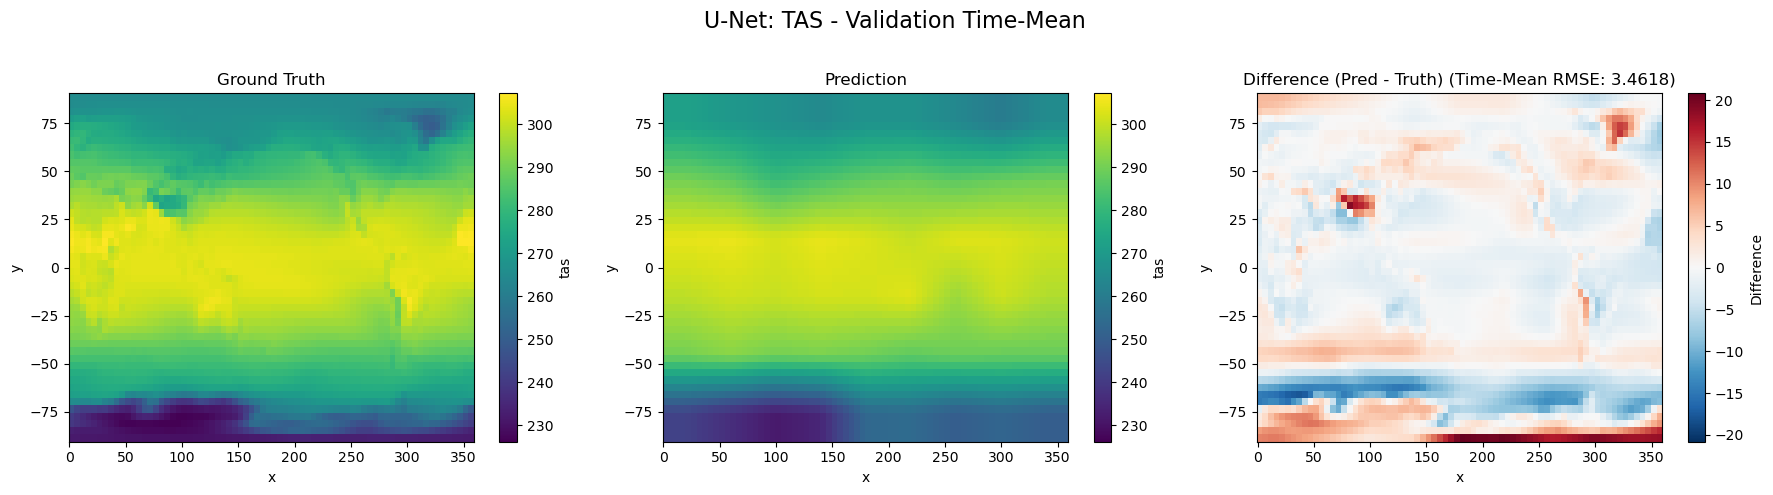

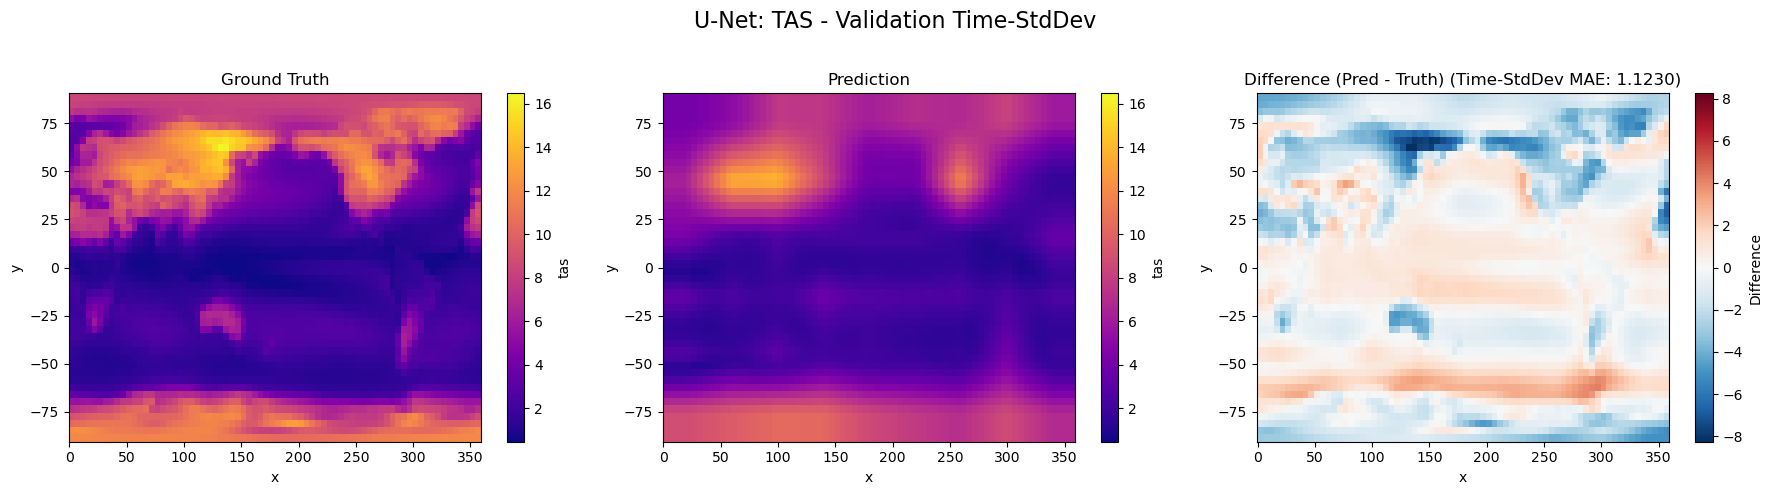

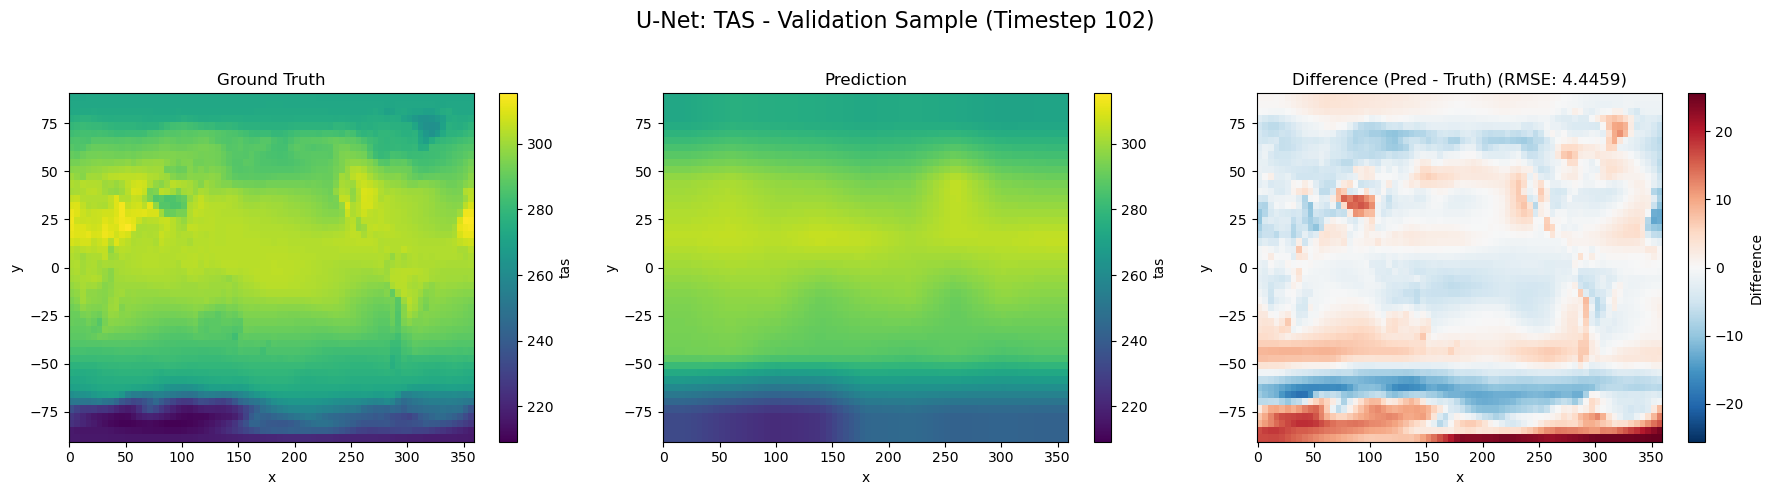

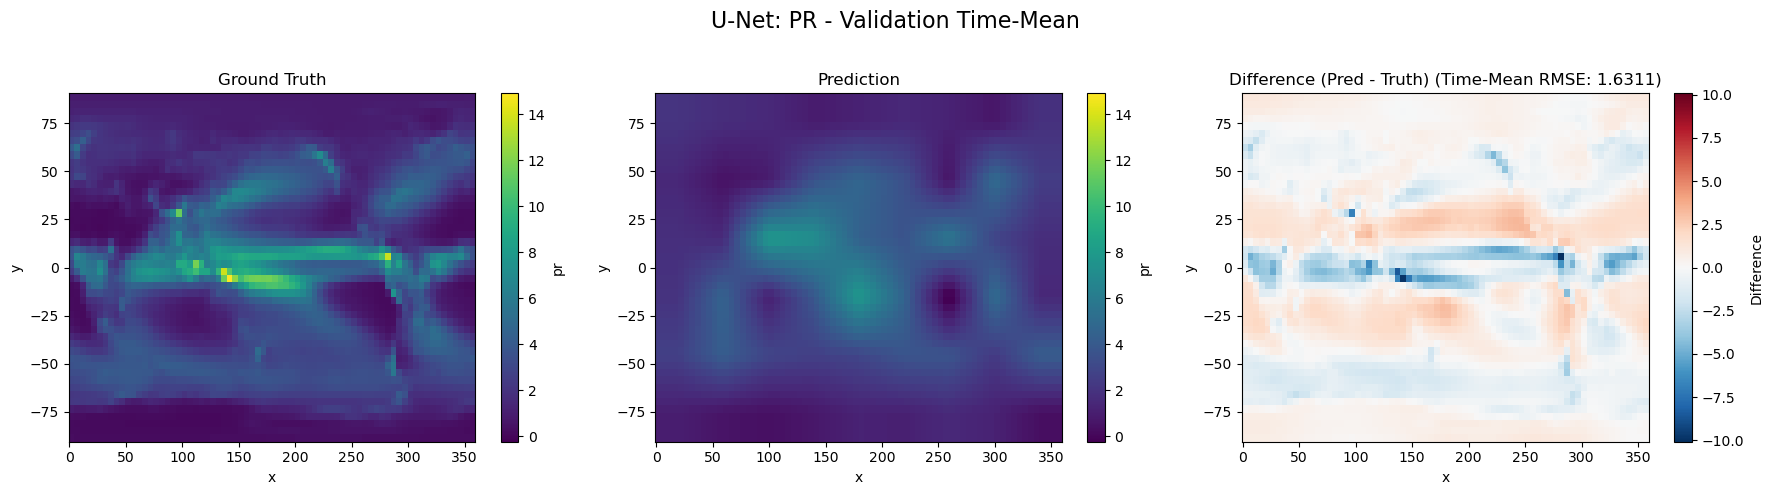

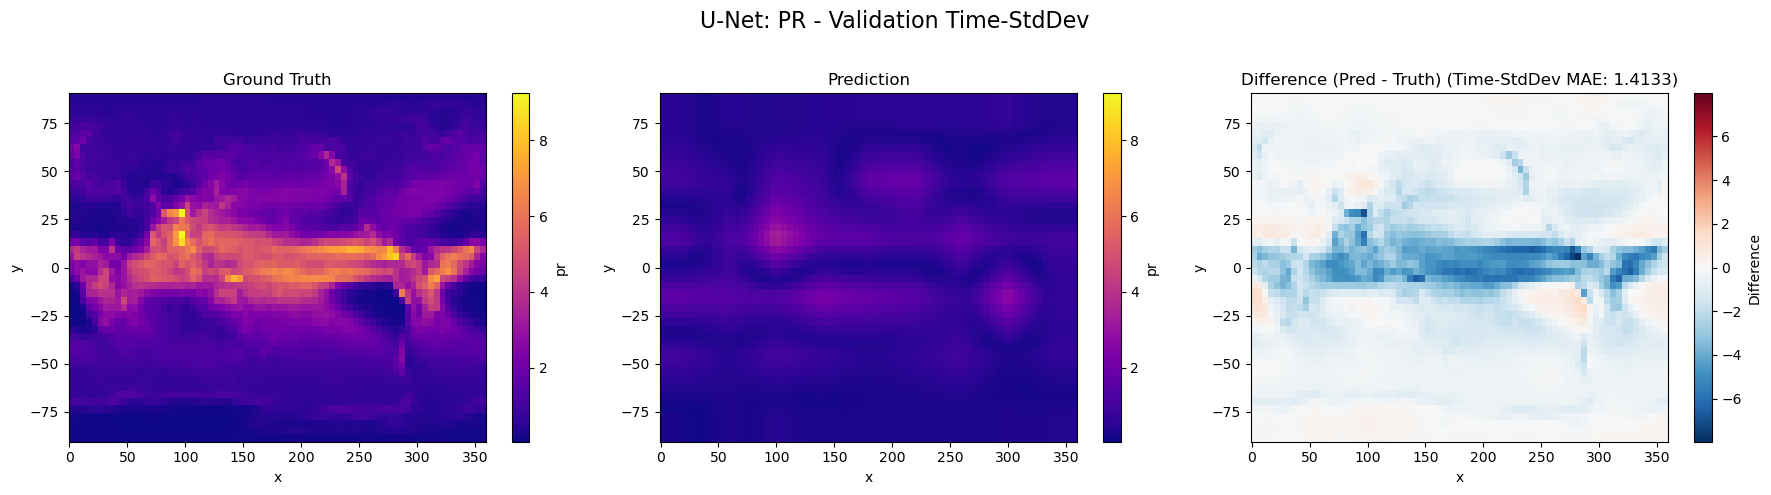

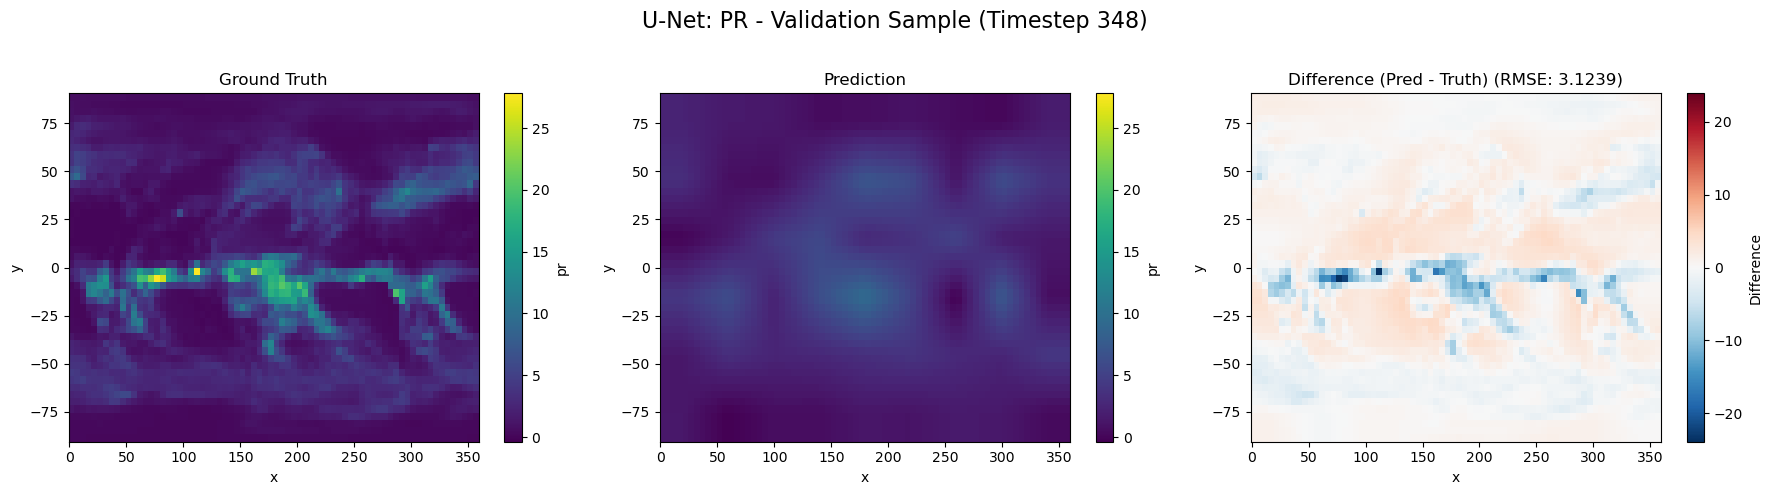

In [11]:
# Cell 10: Visualization Script (Optional)

try:
    val_preds_loaded = np.load("val_preds.npy")
    val_trues_loaded = np.load("val_trues.npy")

    if not hasattr(datamodule, 'lat') or datamodule.lat is None:
        print("Datamodule not fully set up for visualization. Setting it up...")
        # datamodule.prepare_data() # Should have been called by trainer
        datamodule.setup(stage="fit") # Ensure lat, lon, etc. are available

    lat, lon = datamodule.get_coords()
    output_vars = config["data"]["output_vars"] 
    area_weights_vis = datamodule.get_lat_weights() 
    
    time_val_coords = np.arange(val_preds_loaded.shape[0])

    print(f"\n--- Visualizing Validation Predictions for U-Net ---")
    for i, var_name in enumerate(output_vars):
        pred_xr = xr.DataArray(val_preds_loaded[:, i], dims=["time", "y", "x"], 
                               coords={"time": time_val_coords, "y": lat, "x": lon}, name=var_name)
        true_xr = xr.DataArray(val_trues_loaded[:, i], dims=["time", "y", "x"], 
                               coords={"time": time_val_coords, "y": lat, "x": lon}, name=var_name)

        pred_mean = pred_xr.mean("time")
        true_mean = true_xr.mean("time")
        mean_rmse_var = np.sqrt(((pred_mean - true_mean) ** 2).weighted(area_weights_vis).mean()).item()
        plot_comparison(true_mean, pred_mean, 
                        f"U-Net: {var_name.upper()} - Validation Time-Mean",
                        metric_val=mean_rmse_var, metric_name="Time-Mean RMSE")

        pred_std = pred_xr.std("time")
        true_std = true_xr.std("time")
        std_mae_var = np.abs(pred_std - true_std).weighted(area_weights_vis).mean().item()
        plot_comparison(true_std, pred_std, 
                        f"U-Net: {var_name.upper()} - Validation Time-StdDev", cmap="plasma",
                        metric_val=std_mae_var, metric_name="Time-StdDev MAE")

        if len(time_val_coords) > 0:
            t_idx_random = np.random.randint(0, len(time_val_coords))
            pred_sample = pred_xr.isel(time=t_idx_random)
            true_sample = true_xr.isel(time=t_idx_random)
            sample_rmse_var = np.sqrt(((pred_sample - true_sample) ** 2).weighted(area_weights_vis).mean()).item()
            plot_comparison(true_sample, pred_sample, 
                            f"U-Net: {var_name.upper()} - Validation Sample (Timestep {t_idx_random})",
                            metric_val=sample_rmse_var, metric_name="RMSE")
        else:
            print(f"No time steps available in validation predictions for {var_name} to plot a random sample.")

except FileNotFoundError:
    print("val_preds.npy or val_trues.npy not found. "
          "Ensure that the training and validation loop (trainer.fit) has been run successfully, "
          "and the on_validation_epoch_end method in ClimateEmulationModule saved these files.")
except AttributeError as e:
    print(f"AttributeError during visualization: {e}. Ensure datamodule is correctly initialized and set up.")
    print("This might happen if 'datamodule' from the training cell is not in scope or wasn't fully set up.")
except Exception as e:
    print(f"An error occurred during visualization: {e}")

